### 1D FORWARD MODELING OF THE ZERO-ANGLE ULTRASONIC WAVEFORM IN A DOUBLE DIRECT SHEAR EXPERIMENT

In [1]:
import glob
from scipy.signal import find_peaks
import numpy as np
import pandas as pd
from numpy import linalg as LA
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import json
from LAB_UW_forward_modeling import *
from LAB_UW_functions import *
import numpy as np
from multiprocessing import Pool, cpu_count
from random import randint



#### Plot options: rationalize in a dedicated file

In [2]:
# Define your palette
colors = {
    'reseda_green': '#788054',
    'dutch_white': '#E0D6B4',
    'khaki': '#CABB9E',
    'platinum': '#E7E5E2',
    'black_olive': '#322D1E'
}

# Define font size
font_size = 30  # Same as the make_movie title font size

#### Few function for using mechanical data: they should be in a dedicated file

In [3]:
def find_mechanical_data(file_path_list, pattern):
    """
    Trova un file specifico all'interno di una lista di percorsi dei file utilizzando un pattern.
    
    Args:
        file_path_list (list): Lista di percorsi dei file in cui cercare il file.
        pattern (str): Pattern per il nome del file da cercare.
    
    Returns:
        str: Percorso completo del file trovato, o None se non viene trovato nessun file corrispondente.
    """
    for file_path in file_path_list:
        if glob.fnmatch.fnmatch(file_path, pattern):
            print("MECHANICAL DATA CHOOSEN:", file_path)
            return file_path
    return None  # Nessun file trovato nella lista
    

def find_sync_values(mech_data_path):
    """
    Trova i valori di picco sincronizzazione all'interno di un file di dati meccanici.

    Questa funzione legge un file CSV contenente dati meccanici, estrae la colonna
    relativa alla sincronizzazione e individua i picchi di sincronizzazione in base
    ai parametri specificati.

    Args:
        mech_data_path (str): Percorso del file CSV contenente i dati meccanici.

    Returns:
        numpy.ndarray: Un array NumPy contenente gli indici dei picchi di sincronizzazione
                       trovati nei dati meccanici.
    """
    mech_data = pd.read_csv(mech_data_path, sep=',', skiprows=[1])
    sync_data = mech_data.sync
    
    # Trova i picchi di sincronizzazione nei dati sincronizzazione
    sync_peaks, _ = find_peaks(sync_data, prominence=4.2, height=4)
    return mech_data, sync_data, sync_peaks

def plot_sync_peaks(sync_data, sync_peaks, experiment_name):
    """
    Visualizza i picchi di sincronizzazione su un grafico dei dati di sincronizzazione.

    Questa funzione prende i dati di sincronizzazione e gli indici dei picchi di sincronizzazione,
    quindi crea un grafico per visualizzare sia i dati di sincronizzazione che i picchi di sincronizzazione
    evidenziati in rosso.

    Args:
        sync_data (numpy.ndarray): Array NumPy contenente i dati di sincronizzazione.
        sync_peaks (numpy.ndarray): Array NumPy contenente gli indici dei picchi di sincronizzazione.
        experiment_name (str): Nome dell'esperimento o della prova da visualizzare nel titolo del grafico.
    """

#### GET OBSERVED DATA


In [4]:
# LOAD SOURCE DATA 
def load_UW_SOURCE_data(uw_sensor_id):
    '''
    TO BE IMPLLEMENTED 
    '''
    return
 # NB: these are the data for the S sensors of 13 mm. We need those for the smaller ones for exp s0109

machine_name = "on_bench"
experiment_name = "glued_pzt"           
data_type = "data_analysis/wavelets_from_glued_pzt"
infile_path_list_pulse  = make_infile_path_list(machine_name,experiment_name,data_type)
pulse_list = []
pulse_metadata_list = []
t_pulse_list = []
time_span = []
for pulse_path in sorted(infile_path_list_pulse): 
    pulse, pulse_metadata = load_waveform_json(pulse_path)
    t_pulse = np.array(pulse_metadata['time_ax_waveform'])
    time_span.append(np.ptp(t_pulse))
    pulse_list.append(pulse)
    pulse_metadata_list.append(pulse_metadata)
    t_pulse_list.append(t_pulse)
    # plt.plot(t_pulse, pulse)
time_span = min(time_span)              # pulse length: it is needed to choose where to evaluate waveform mis-fit and amplitude measure

# LOAD MECHANICAL DATA
## PATH TO DATA 
machine_name = "Brava_2"
experiment_name = "s0108"
data_type_uw = 'data_tsv_files'
data_type_mech = 'mechanical_data'
sync_file_pattern = '*s*_data_rp' #pattern to find specific experiment in mechanical data

infile_path_list_mech = make_infile_path_list(machine_name, experiment_name, data_type=data_type_mech)
mech_data_path= find_mechanical_data(infile_path_list_mech, sync_file_pattern)
mech_data, _ , sync_peaks = find_sync_values(mech_data_path)
# plot_sync_peaks(sync_data, sync_peaks, experiment_name)

## LOAD ULTRASONIC WAVEFORM DATA
infile_path_list_uw = sorted(make_infile_path_list(machine_name,experiment_name, data_type=data_type_uw))
choosen_uw_file = 0                # which of the sorted UW files analized. It must correspond to the part of mechanical data extracted!
infile_path_uw = infile_path_list_uw[choosen_uw_file]      
print('LOADING UW DATA IN %s: ' %infile_path_uw)
data_OBS,metadata = make_UW_data(infile_path_uw)
t_OBS = metadata['time_ax_waveform']




MECHANICAL DATA CHOOSEN: /home/michele/Desktop/Dottorato/active_source_implementation/experiments_Brava_2/s0108/mechanical_data/s0108sw06car102030_data_rp
LOADING UW DATA IN /home/michele/Desktop/Dottorato/active_source_implementation/experiments_Brava_2/s0108/data_tsv_files/001_run_in_10MPa.bscan.tsv: 


In [5]:
#### PICKED MANUALLY FOR PLOTTING POURPOSE: CUT PRECISELY AROUND THE MECHANICAL DATA OF THE STEP
if experiment_name == "s0108":
    steps_carrara = [5582,8698,15050,17990,22000,23180,36229,39391,87940,89744,126306,128395,134000,135574,169100,172600,220980,223000,259432, 261425,266429,268647,279733,282787,331437,333778,369610,374824]
    sync_peaks = steps_carrara 

if experiment_name == "s0103":
    steps_mont = [4833,8929,15166,18100,22188,23495,36297,39000,87352,89959,154601,156625,162000,165000,168705,170490,182000,184900,233364,235558,411811,462252]
    sync_peaks = steps_mont

In [6]:
# CHOOSE OUTFILE_PATH
outdir_path_l2norm= make_data_analysis_folders(machine_name=machine_name, experiment_name=experiment_name,data_types=["poster_EGU_2024"])
outfile_path_list_uw = []
for infile_path in infile_path_list_uw:
    ooutfile_name = os.path.basename(infile_path).split('.')[0] 
    outfile_path = os.path.join(outdir_path_l2norm[0], ooutfile_name)
    outfile_path_list_uw.append(outfile_path)
    print(outfile_path)

outfile_path = outfile_path_list_uw[0]

/home/michele/Desktop/Dottorato/active_source_implementation/experiments_Brava_2/s0108/data_analysis/poster_EGU_2024/001_run_in_10MPa
/home/michele/Desktop/Dottorato/active_source_implementation/experiments_Brava_2/s0108/data_analysis/poster_EGU_2024/002_step_1_3_1_10MPa
/home/michele/Desktop/Dottorato/active_source_implementation/experiments_Brava_2/s0108/data_analysis/poster_EGU_2024/003_step_1_10_1_10MPa
/home/michele/Desktop/Dottorato/active_source_implementation/experiments_Brava_2/s0108/data_analysis/poster_EGU_2024/004_step_1_30_1_10MPa
/home/michele/Desktop/Dottorato/active_source_implementation/experiments_Brava_2/s0108/data_analysis/poster_EGU_2024/005_step_1_100_1_10MPa
/home/michele/Desktop/Dottorato/active_source_implementation/experiments_Brava_2/s0108/data_analysis/poster_EGU_2024/006_run_in_20MPa
/home/michele/Desktop/Dottorato/active_source_implementation/experiments_Brava_2/s0108/data_analysis/poster_EGU_2024/007_step_1_10_1_20MPa
/home/michele/Desktop/Dottorato/activ

#### PREPROCESSING: SPEED UP FORWARD MODELING BY REMOVING USELESS INFORMATION ("NOISE")

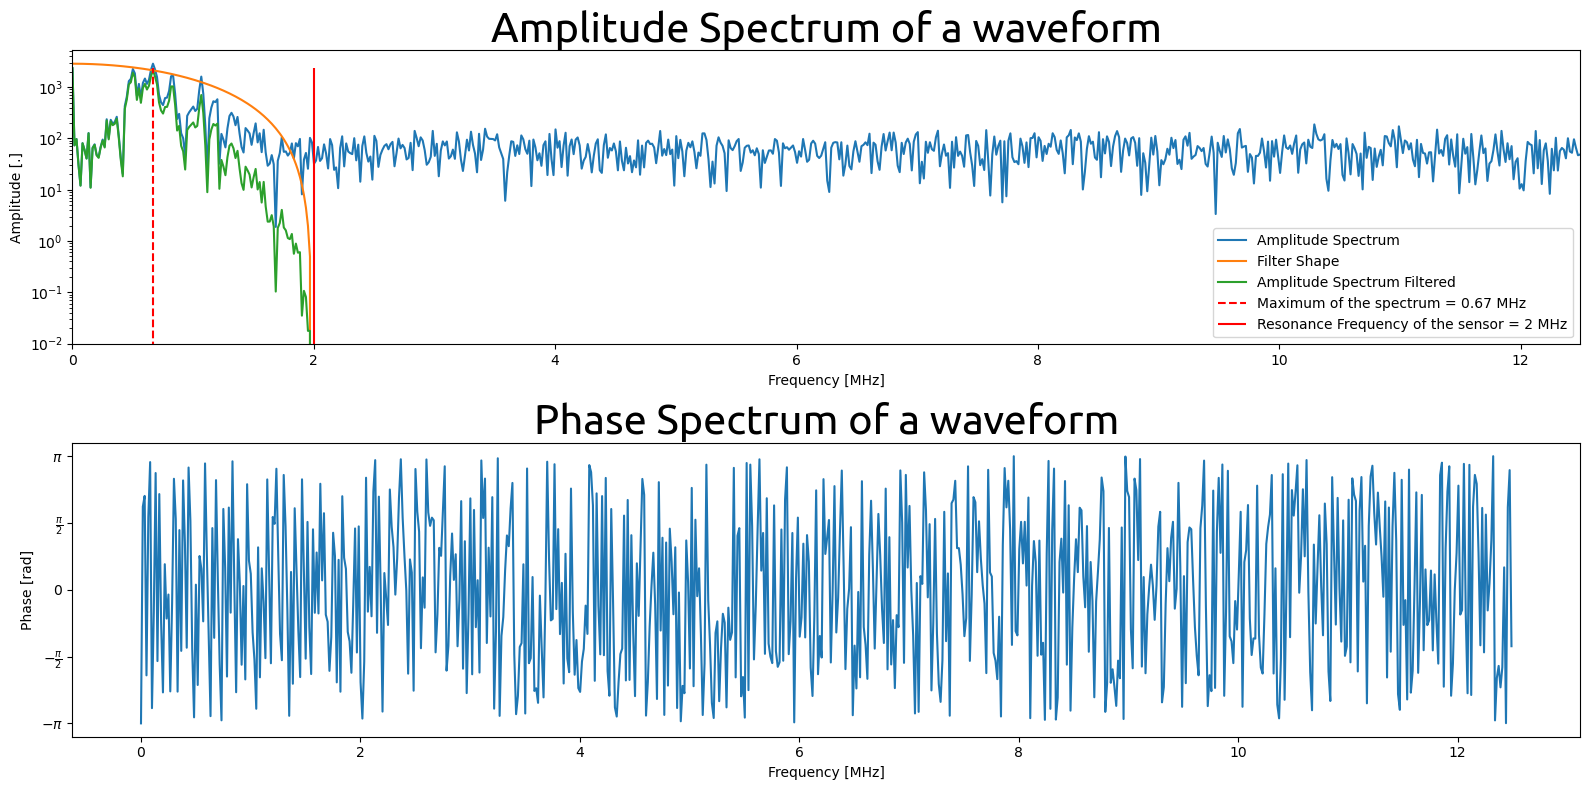

In [7]:
# REMOVEVE EVERYTHING BEFORE initial_time_removed: given the velocity in plays, there can be only noise there.
initial_time_removed = 10         # [mus] 
t_OBS,data_OBS = t_OBS[t_OBS>initial_time_removed], data_OBS[:,t_OBS>initial_time_removed]

# FREQUENCY LOW PASS:
# reduce computation time 
# # assumtion: there is no point to simulate anything below SNR of 1
freq_cut = 2                  # [MHz]   maximum frequency of the data we want to reproduce  
data_OBS_filtered, _  = signal2noise_separation_lowpass(data_OBS[2000],metadata,freq_cut=freq_cut)


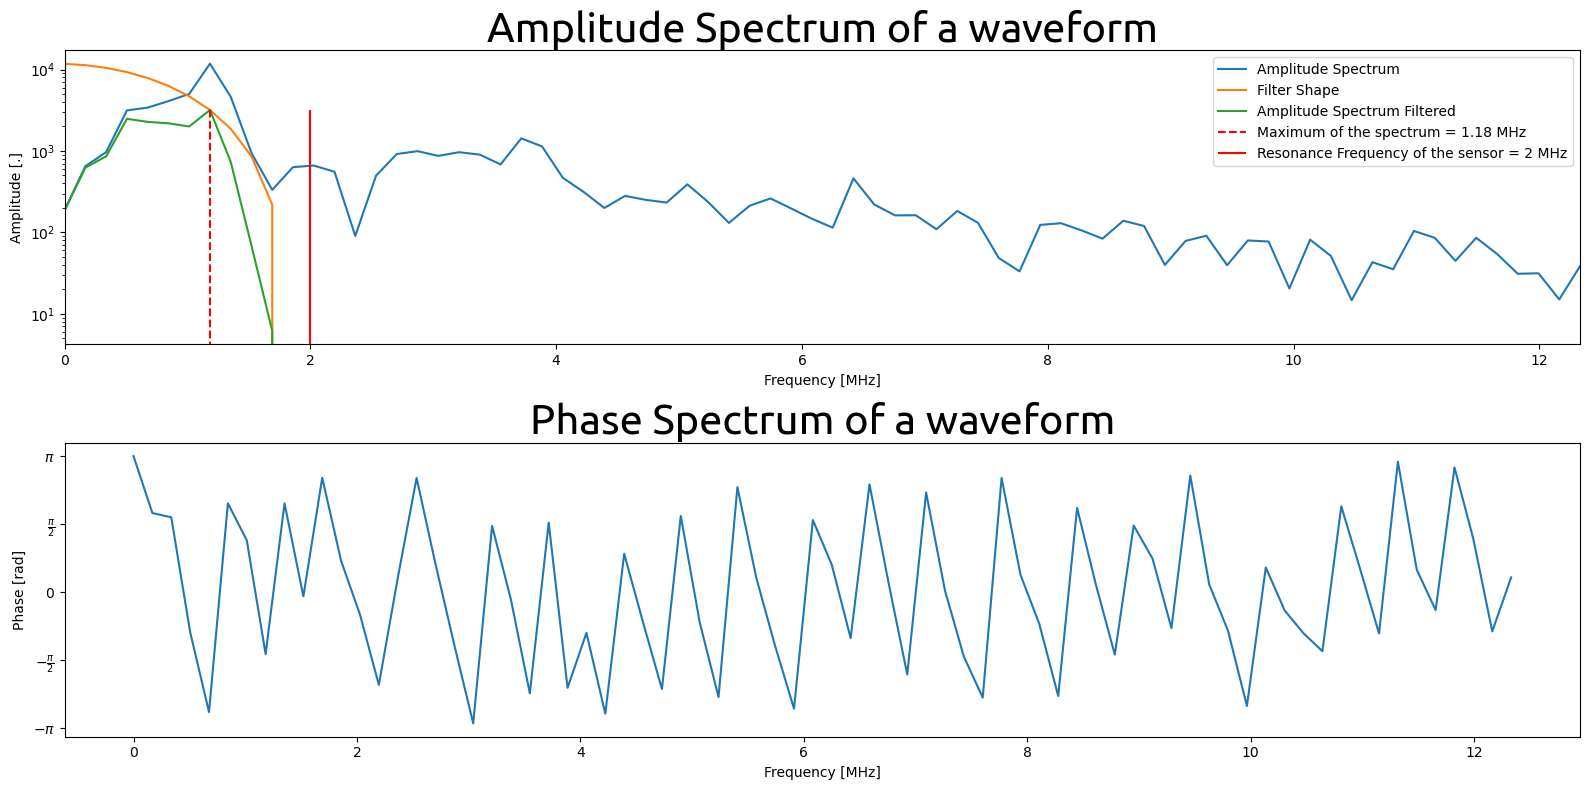

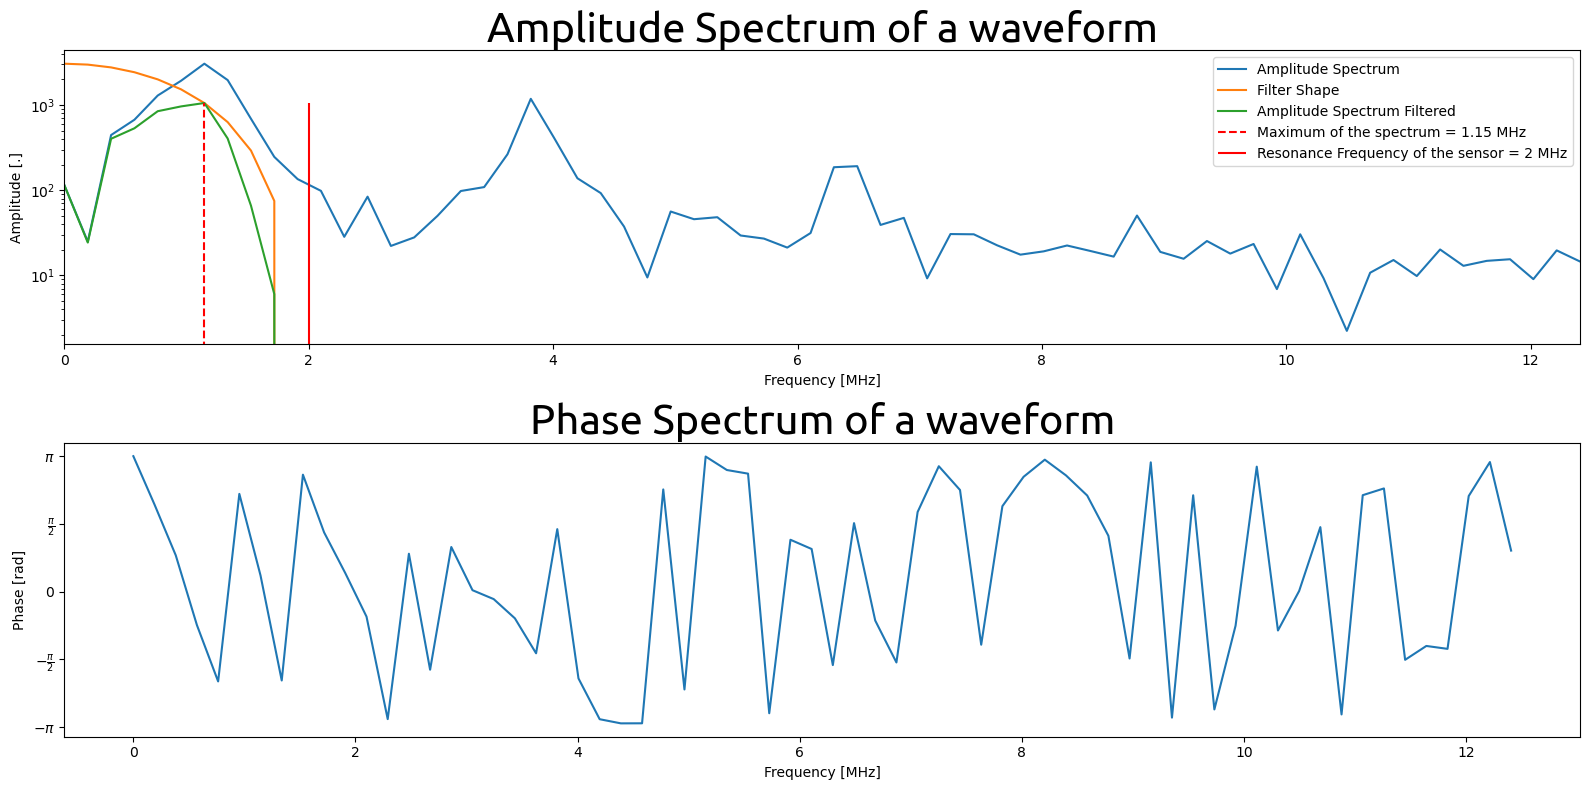

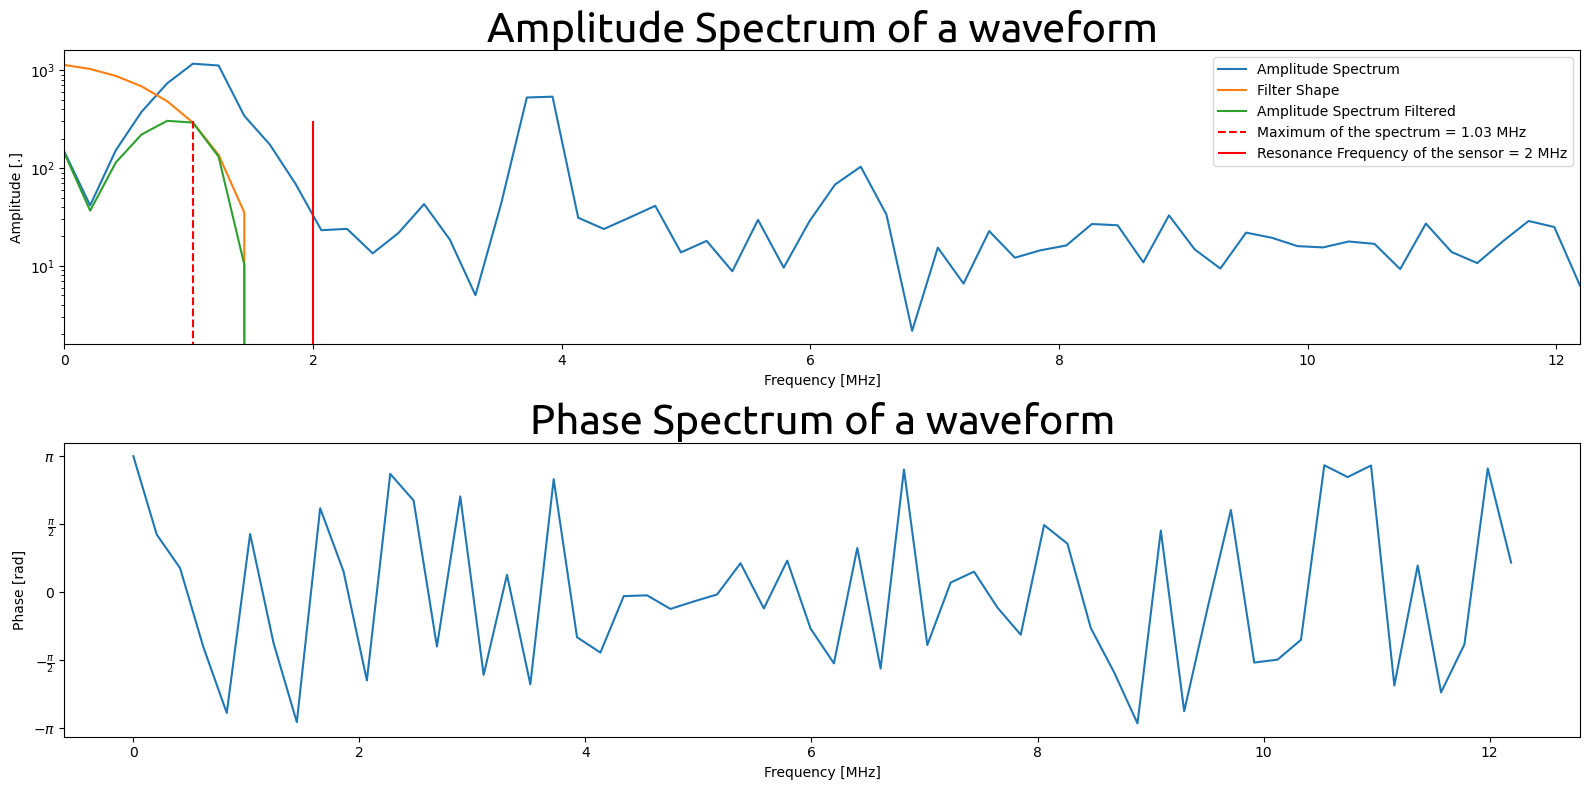

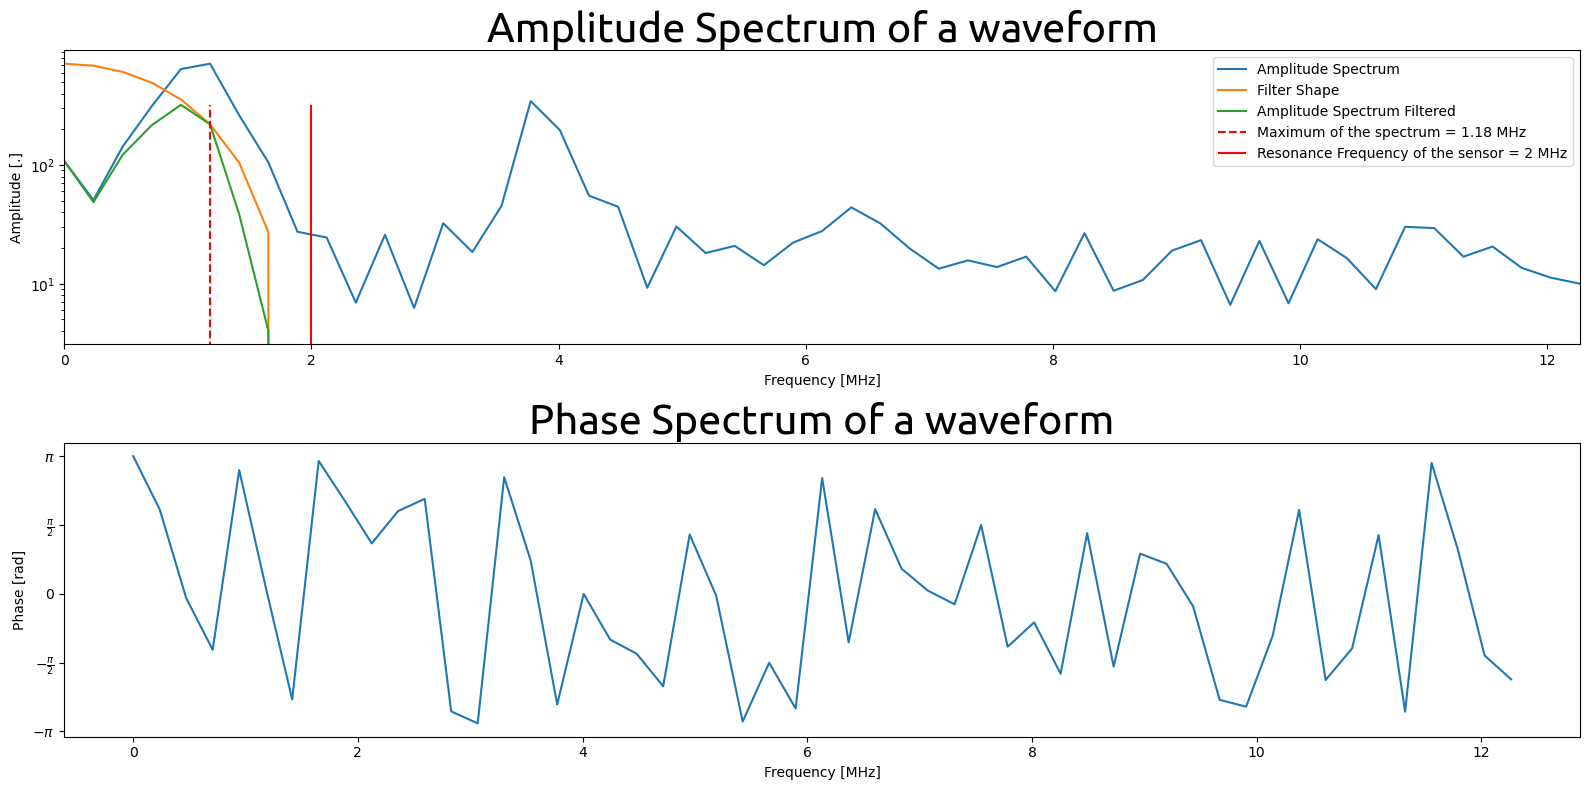

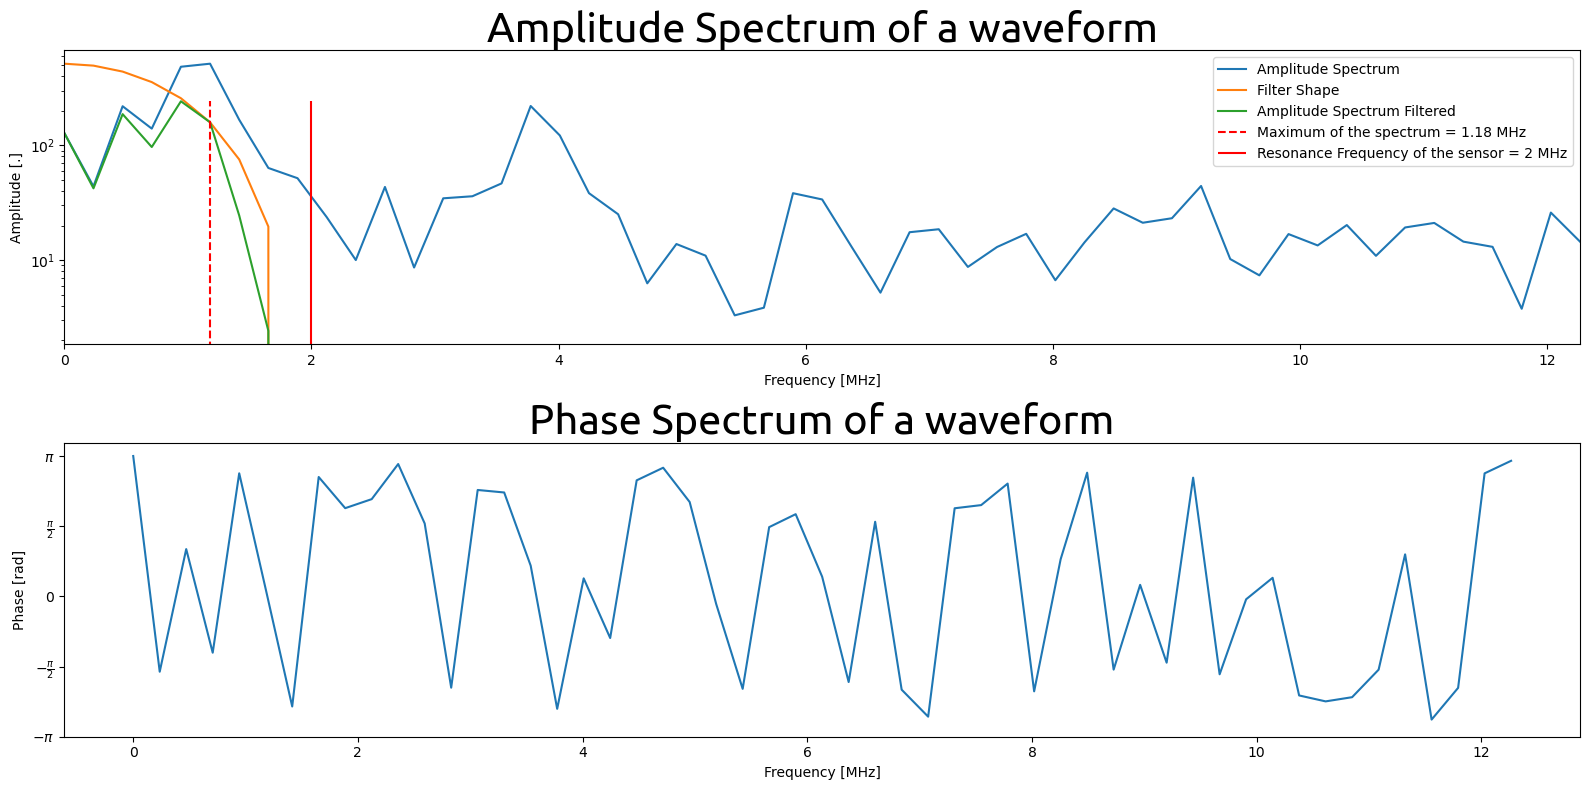

In [8]:

for i in range(len(pulse_list)):
    pulse_list[i], _  = signal2noise_separation_lowpass(pulse_list[i],pulse_metadata_list[i],freq_cut=freq_cut)
    pulse_list[i] = pulse_list[i] - pulse_list[i][0] 
    # plt.plot(pulse_list[i])



#### Pass everything in reasonable units: cm, $\mu s$, MHz

In [9]:
### INPUT DATA ###
# These are constants through the entire experiment.
side_block_1 = 2               # [cm] width of first side block
side_block_2 = 2               # [cm] width of first gouge layer
central_block = 4.8
pzt_width = 0.1                                 # [cm] its important!
pmma_width = 0.1                                 # [cm] plate supporting the pzt
csteel = 3374 * (1e2/1e6)       # [cm/mus]   steel s-velocity from calibration
cpzt = 2000* (1e2/1e6)         # [cm/mus] s-velocity in piezo ceramic, beetween 1600 (bad coupling) and 2500 (good one). It matters!!!
                                # according to https://www.intechopen.com/chapters/40134   
cpmma = 0.4* 0.1392              # [cm/mus]   plate supporting the pzt


# EXTRACT LAYER THICKNESS FROM MECHANICA DATA
#Choose layer thickness from mechanical data using sync peaks indexes
thickness_gouge_1_list = mech_data.rgt_lt_mm[sync_peaks[2*choosen_uw_file]: sync_peaks[2*choosen_uw_file+1]].values/10  #the velocities are in cm/mus, layer thickness in mm. Divided by ten!!!
thickness_gouge_2_list = thickness_gouge_1_list

# WRONG THICKNESS: do not account for thinning 
# thickness_gouge_1_list = 0.4 * np.ones(thickness_gouge_1_list.shape)     # [cm]
# thickness_gouge_2_list


# TRASMISSION AT 0 ANGLE: ONE RECEIVER, ONE TRASMITTER. 
# Fix the zero of the ax at the beginning of side_block_1. 
# The trasmitter is solidal with the side_block_1, so its coordinates are constant
# The receiver moves with the side_block_1, so its coordinates must be corrected for the layer thickness. It is computed in the for loop
# Must be made more efficient, bu at the mooment is at list clear
x_trasmitter = 1                              # [cm] position of the trasmitter from the beginning of the sample: the distance from the beginning of the block is fixed.
# x_receiver_list = sum(saple_dimensions) - 0.95


# GUESSED VELOCITY MODEL OF THE SAMPLE
# S- velocity of gouge to probe. Extract from the literature!
cmin = 600 * (1e2/1e6)        
cmax = 1800 * (1e2/1e6) 
c_step = 50*1e2/1e6
c_gouge_list = np.arange(cmin, cmax,c_step) # choose of velocity in a reasonable range: from pressure-v in air to s-steel velocity



In [10]:

# DEFINE EVALUATION INTERVAL FOR L2 NORM OF THE RESIDUALS
# at the moment the gouge thickness is the same for both the layers, but still the implementation below allowed for differences.
max_travel_time_list = 2*(side_block_1-x_trasmitter)/csteel + thickness_gouge_1_list/cmin+ central_block/csteel + thickness_gouge_1_list/cmin
min_travel_time_list = 2*(side_block_1-x_trasmitter)/csteel + thickness_gouge_1_list/cmax+ central_block/csteel + thickness_gouge_1_list/cmax
idx_travel_time_list = []
for min_travel_time,max_travel_time in zip(min_travel_time_list,max_travel_time_list):
    idx_travel_time = np.where((t_OBS >min_travel_time) & (t_OBS < max_travel_time+time_span))
    idx_travel_time_list.append(idx_travel_time)

 

In [11]:
# DOWNSAMPLING THE WAVEFORMS: FOR PLOTING PURPOSE, WE DO NOT NEED TO PROCESS ALL THE WAVEFORMS
number_of_waveforms_wanted = 3
data_OBS_subset = data_OBS[:sync_peaks[2*choosen_uw_file+1]-sync_peaks[2*choosen_uw_file]] # subsempling on around the step
metadata['number_of_waveforms'] = len(data_OBS_subset)
downsampling = round(metadata['number_of_waveforms']/number_of_waveforms_wanted)
print(f"Number of waveforms wanted: {number_of_waveforms_wanted}\nDownsampling waveforms by a factor: {downsampling}")

# PULSE USED AS ACTIVE SOURCE
choosen_pulse = 0
pulse = pulse_list[choosen_pulse]
t_pulse = t_pulse_list[choosen_pulse]

# # SAVE THE PULSE FOR EGU
# fig = plt.figure(figsize=[16, 8])
# plt.plot(t_pulse,pulse,color=colors['reseda_green'], alpha=0.5,linewidth=3.0, label= "UW across iron block")
# plt.title("Measure the waveform in a homogenus space", fontsize=font_size)
# # plt.xlim([10, 55])
# plt.legend(loc="lower left", fontsize=font_size)
# plt.xlabel("Time [$\mu$s]", fontsize=0.7*font_size)
# plt.ylabel("Amplitude [a.u.]", fontsize=0.7*font_size)
# plt.xticks(fontsize=0.7*font_size)
# plt.yticks(fontsize=0.7*font_size)
# # plt.axis('off')  # Turn off the axis
# outfile_path_pulse_EGU= f"{outfile_path}_pulse.eps"
# plt.savefig(outfile_path_pulse_EGU)
# plt.show()
# plt.close(fig)

# WRONG PULSE EXAMPLE: search manually a pick
# idx_wave_high_signal = 100
# waveform_high_signal = data_OBS[idx_wave_high_signal]
# pulse_start = 462
# pulse_end = 503
# pulse = waveform_high_signal[pulse_start:pulse_end]    
# # t_pulse = t_OBS[pulse_start:pulse_end]
# t_pulse = t_pulse[:len(pulse)]
# len_pulse = t_pulse[-1]-t_pulse[0]
# plt.figure()
# plt.plot(t_pulse,pulse)

Number of waveforms wanted: 3
Downsampling waveforms by a factor: 1039


#### 1)  Normal sequential algorithm

processing waveform at 0 with velocity: 600.000000


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


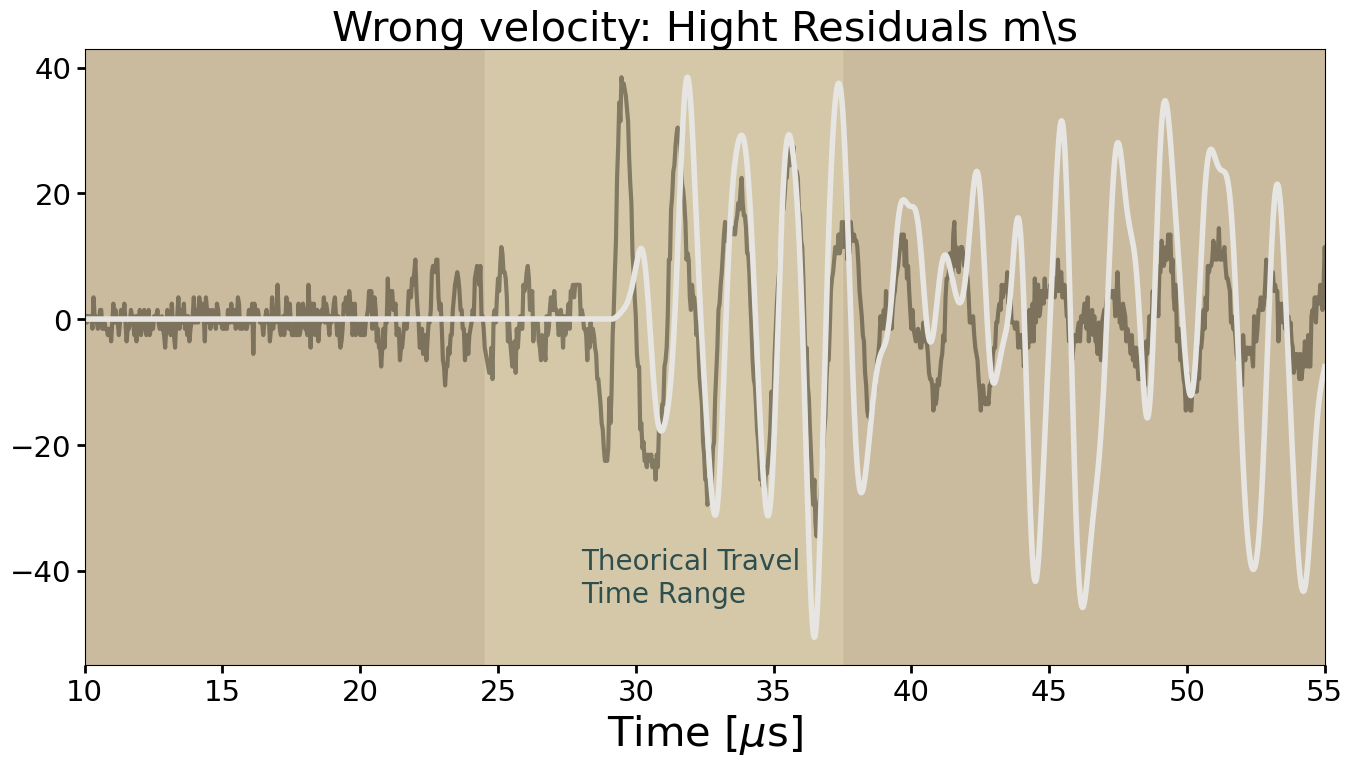

processing waveform at 0 with velocity: 650.000000


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


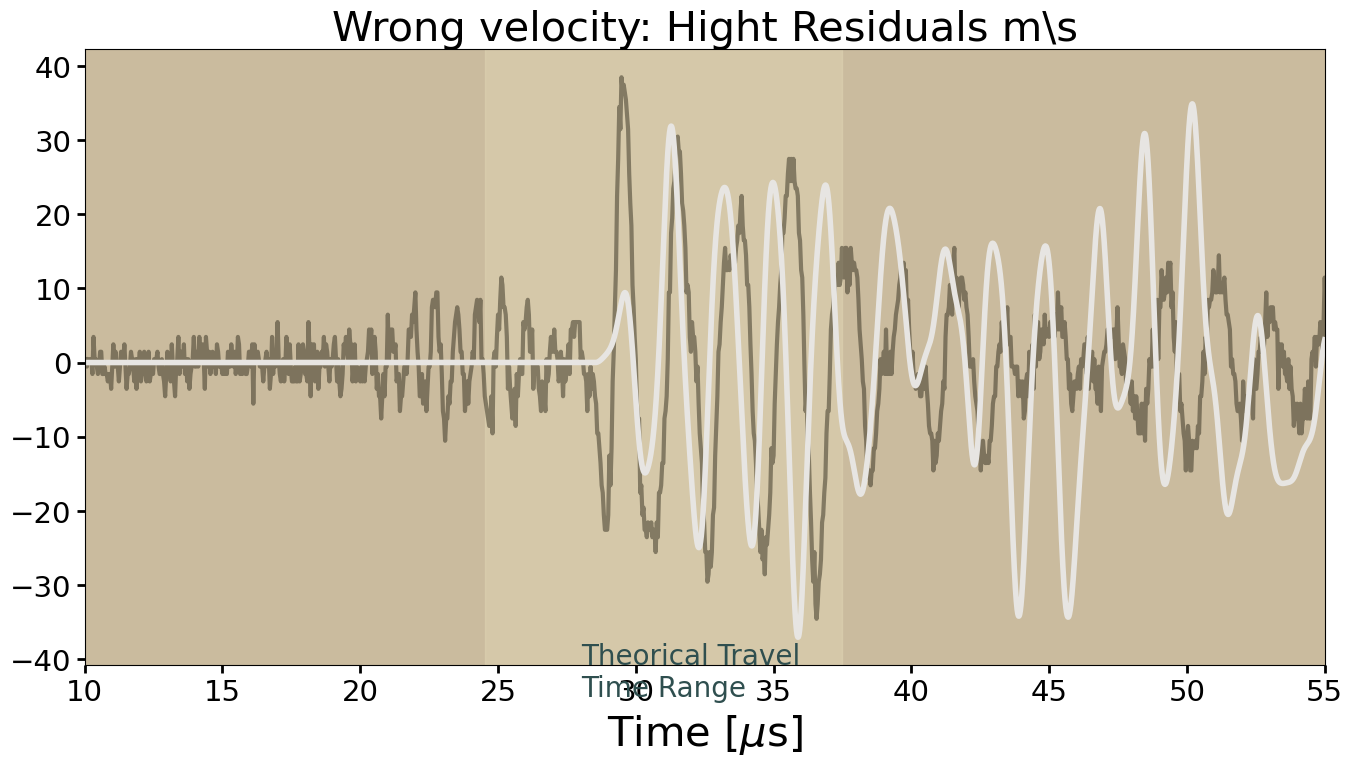

processing waveform at 0 with velocity: 700.000000


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


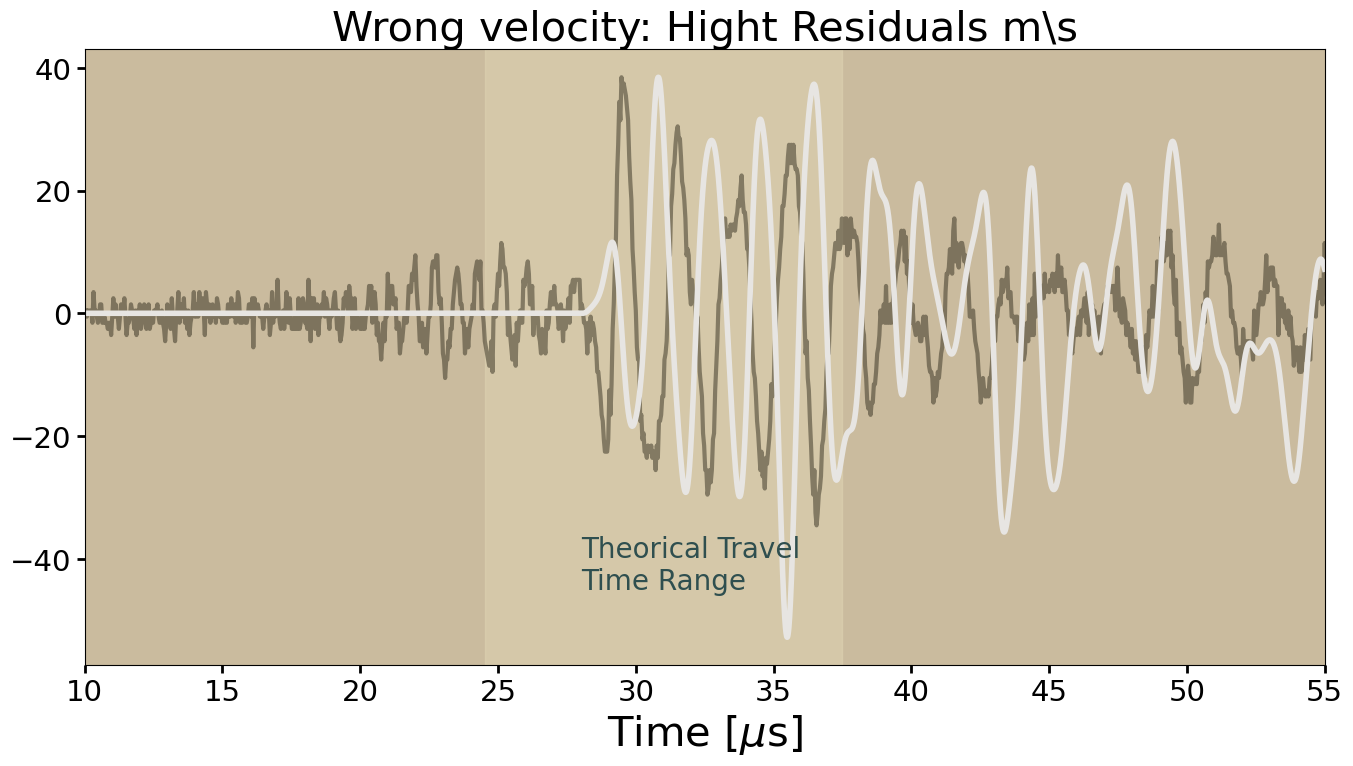

processing waveform at 0 with velocity: 750.000000


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


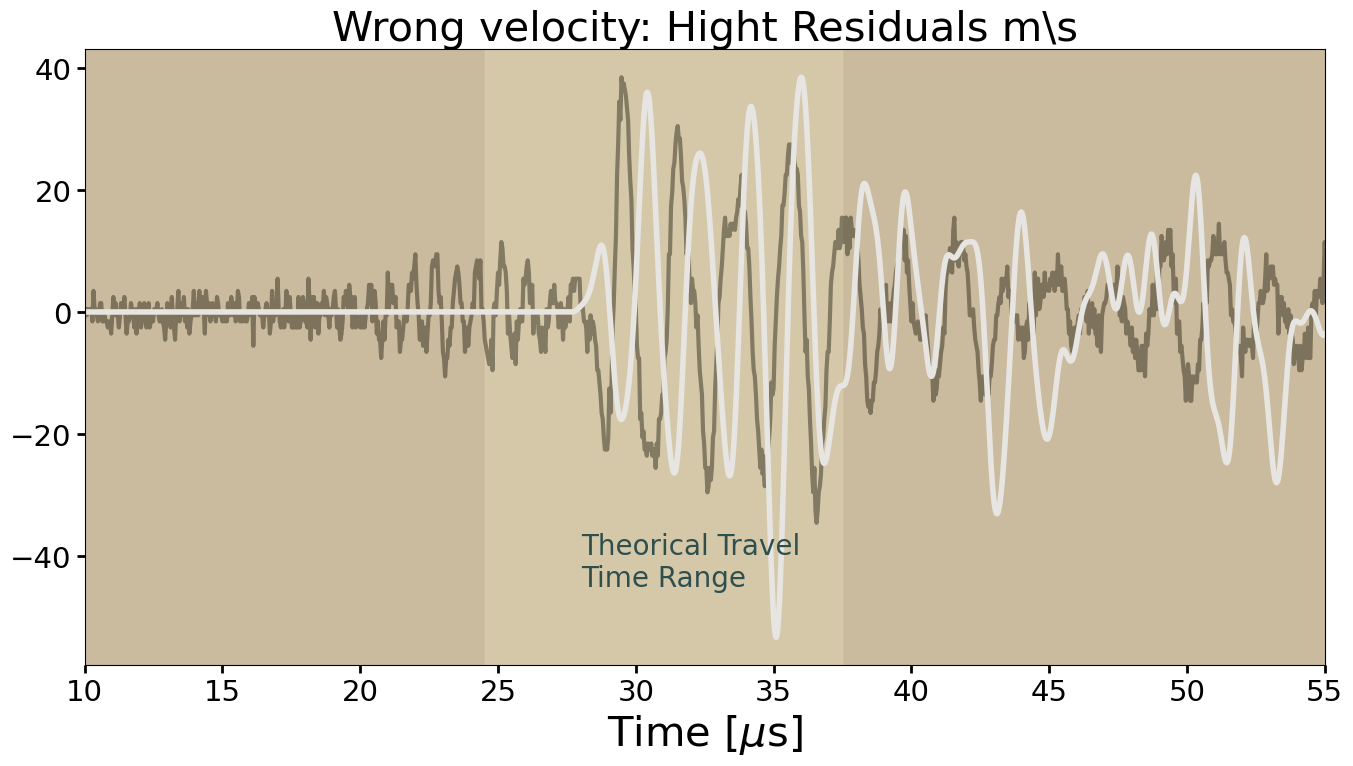

processing waveform at 0 with velocity: 800.000000


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


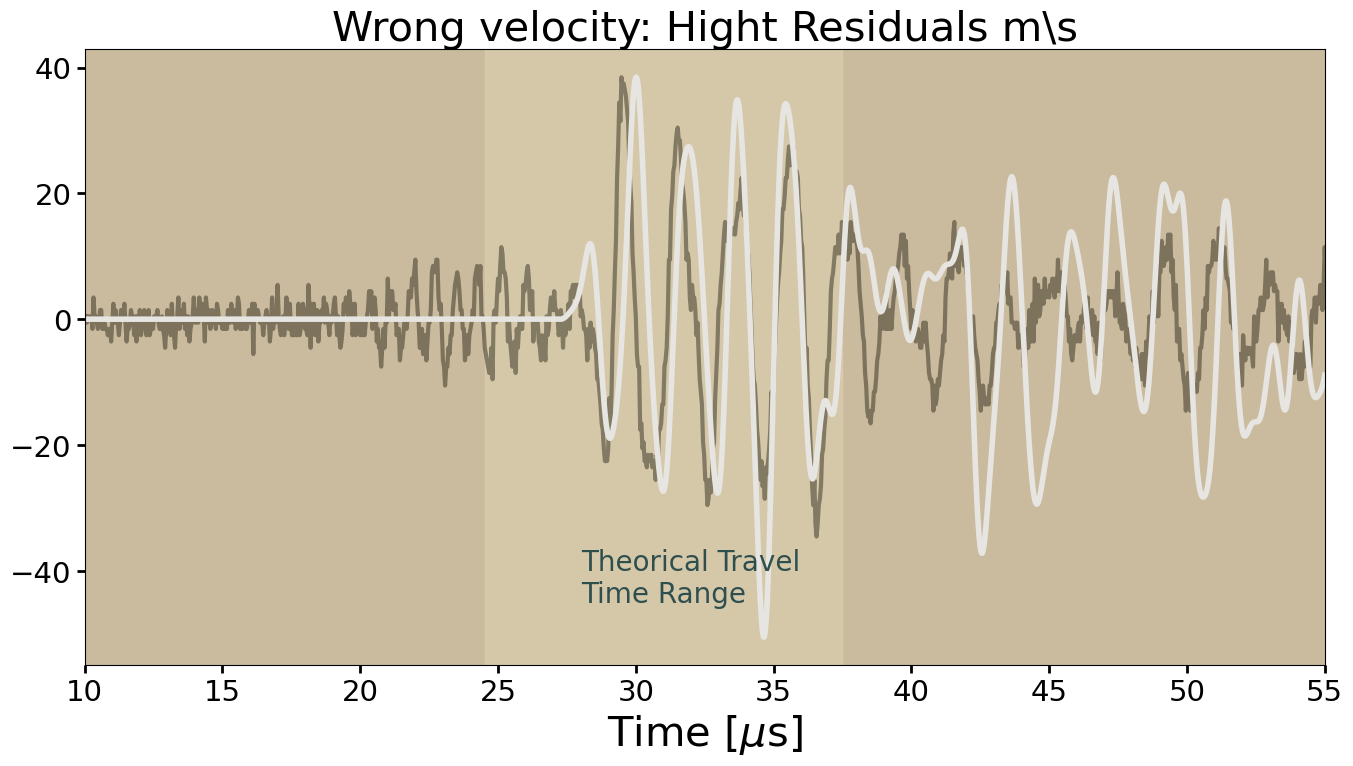

processing waveform at 0 with velocity: 850.000000


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


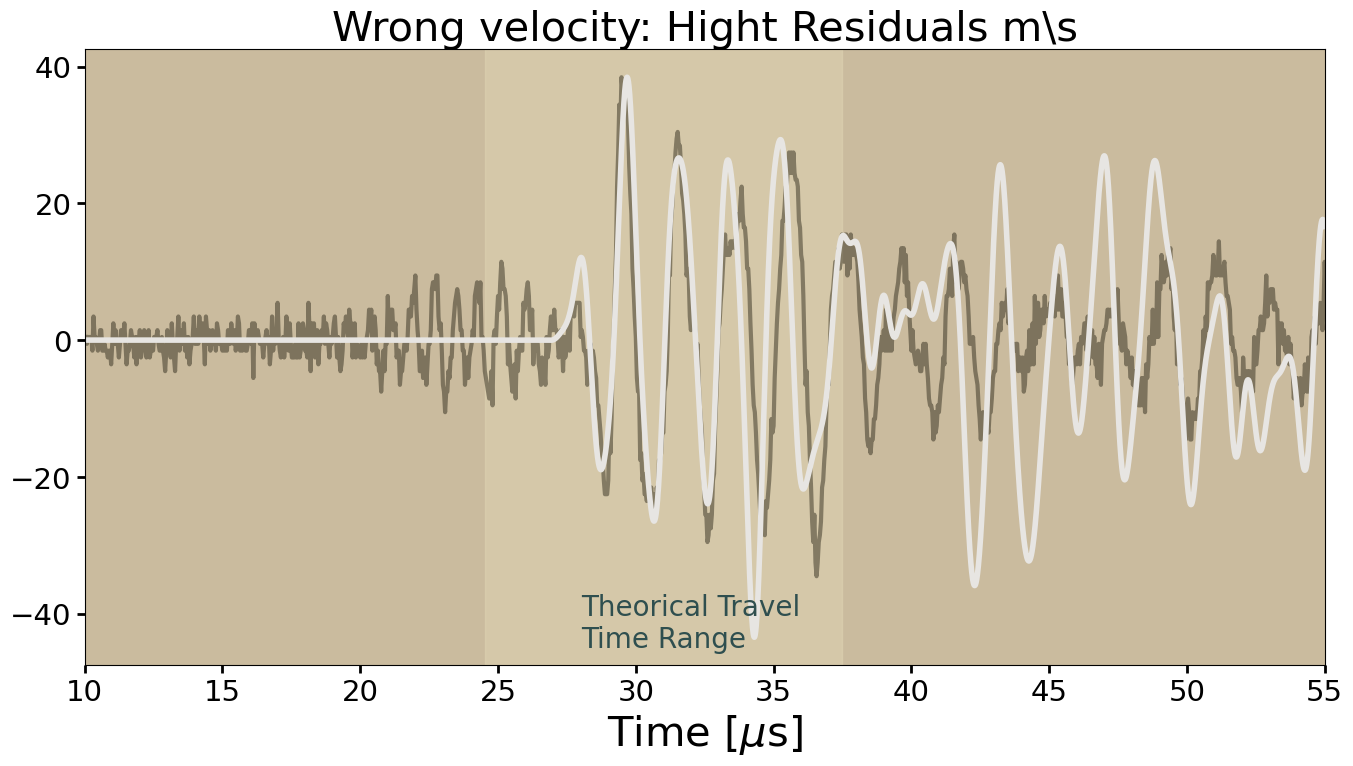

processing waveform at 0 with velocity: 900.000000


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


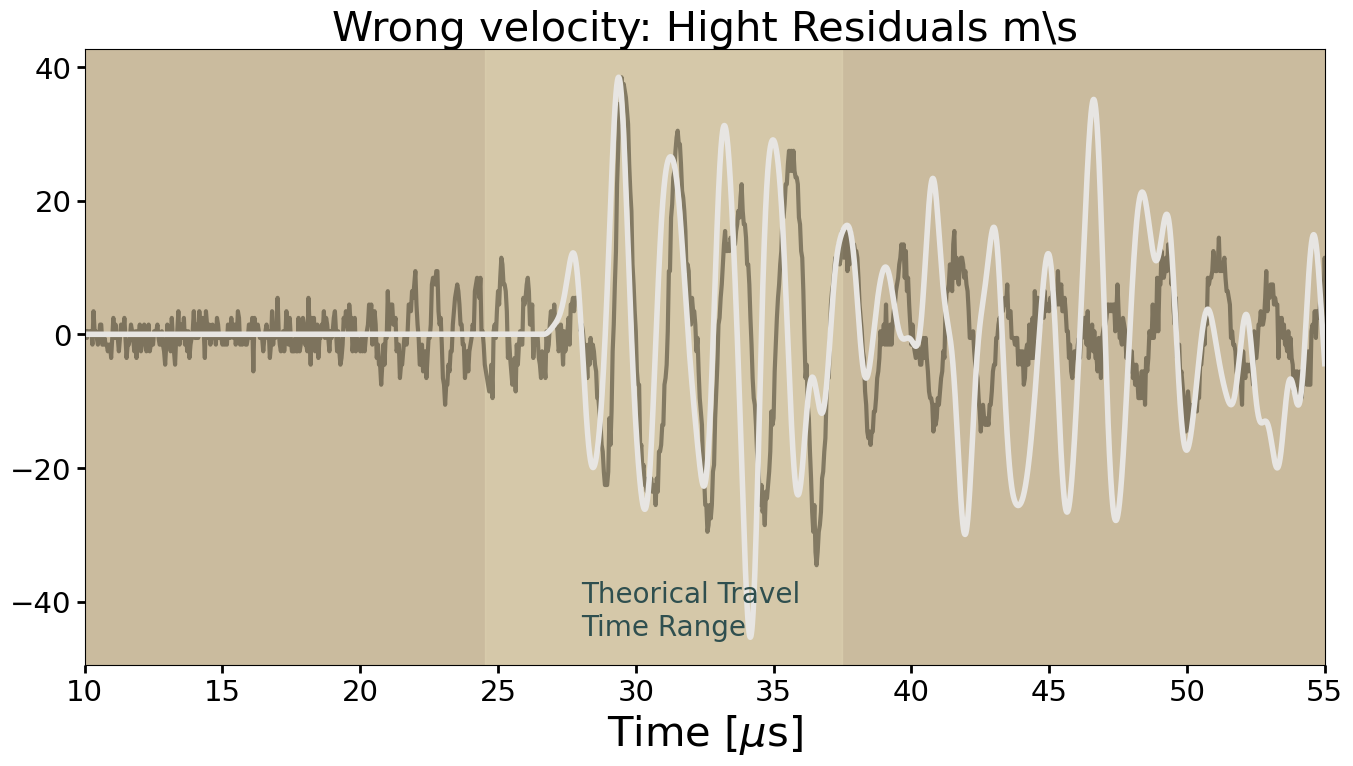

processing waveform at 0 with velocity: 950.000000


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


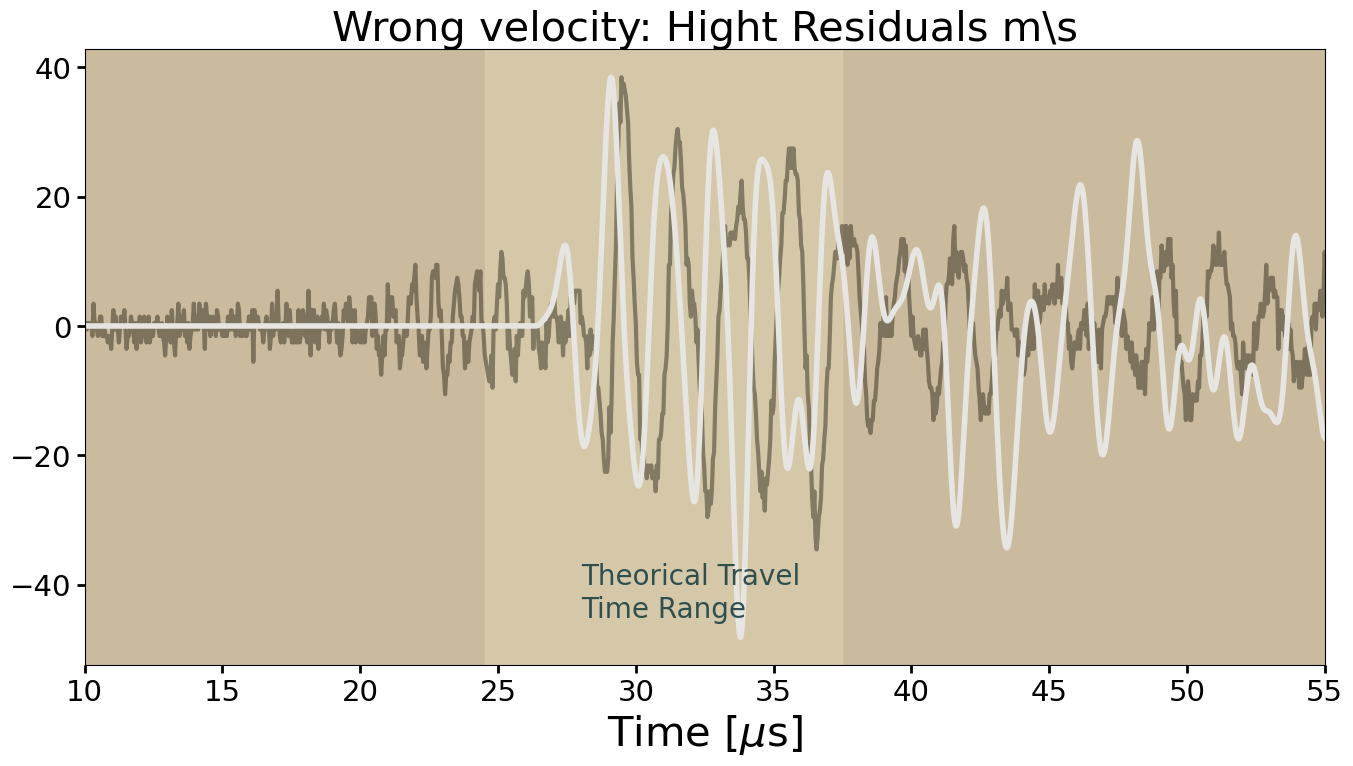

processing waveform at 0 with velocity: 1000.000000


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


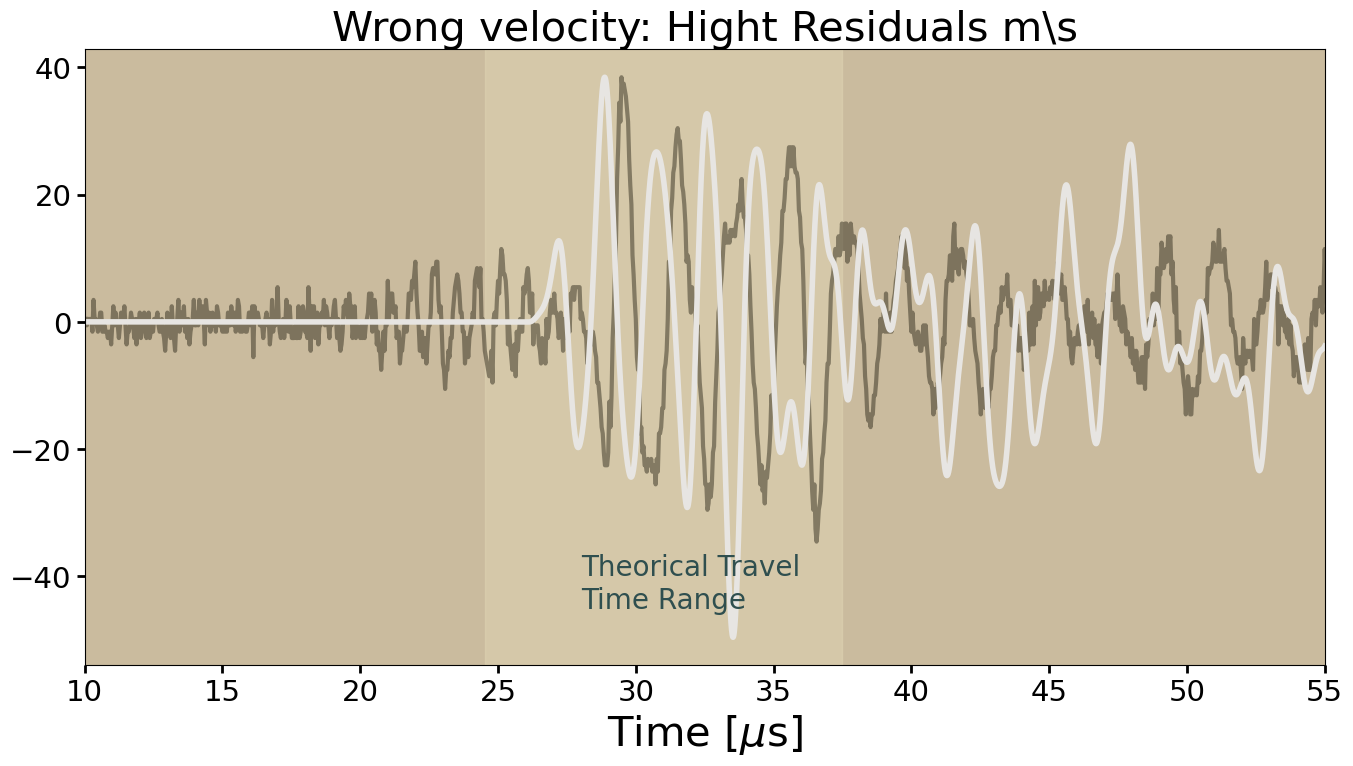

processing waveform at 0 with velocity: 1050.000000


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


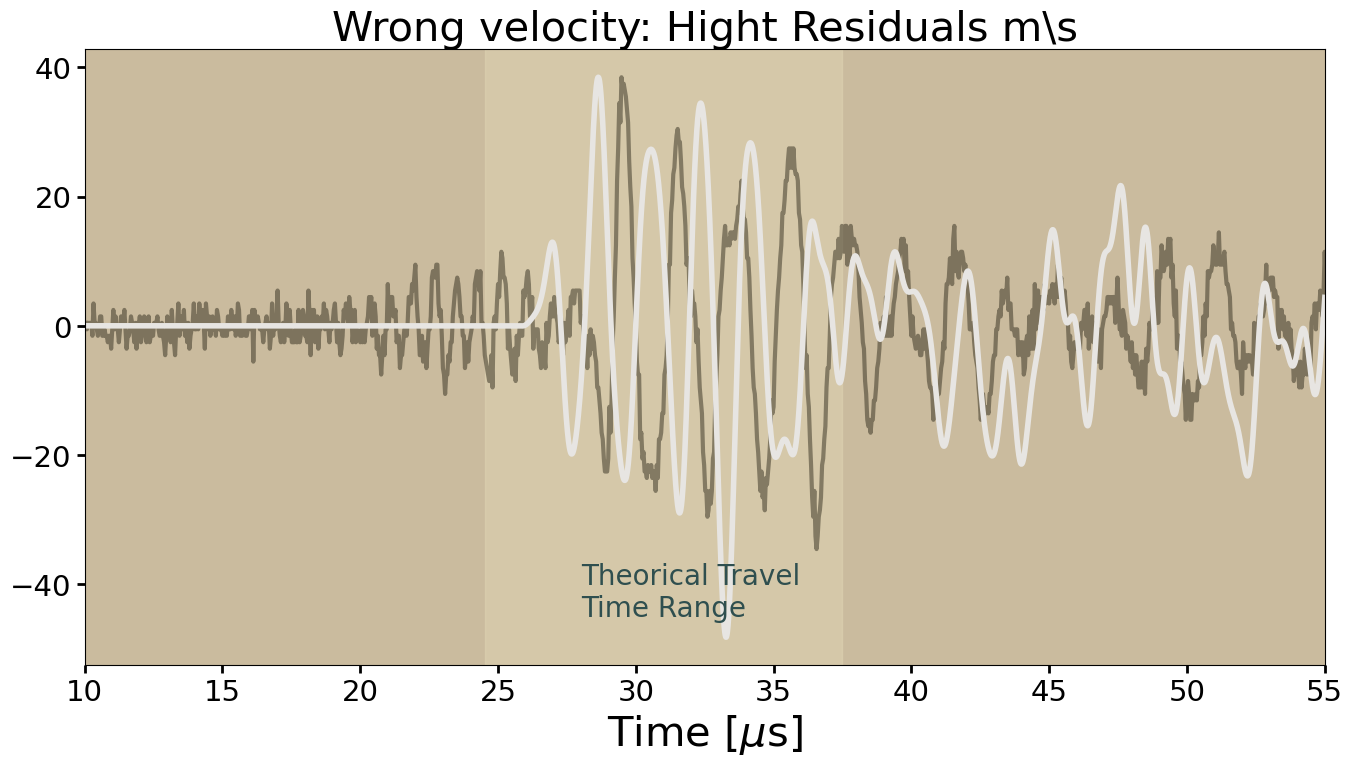

processing waveform at 0 with velocity: 1100.000000


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


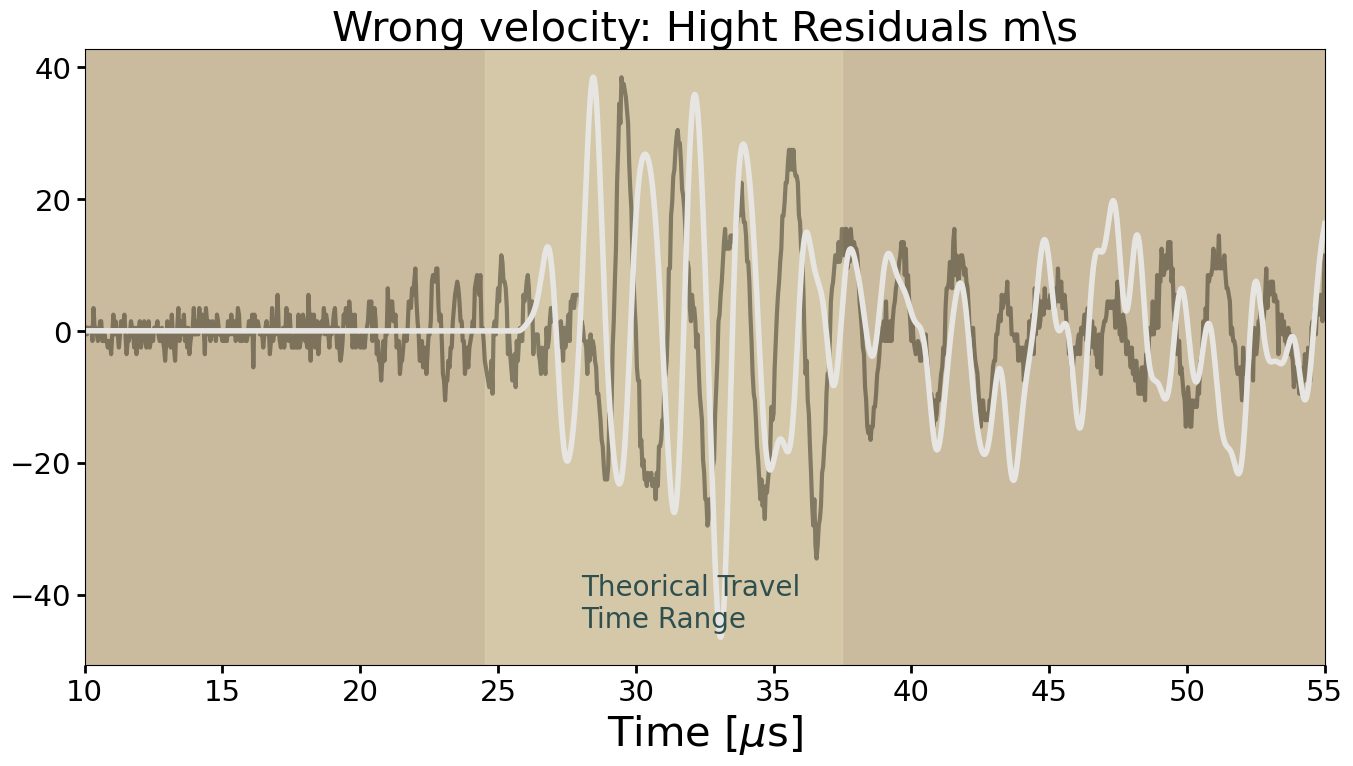

processing waveform at 0 with velocity: 1150.000000


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


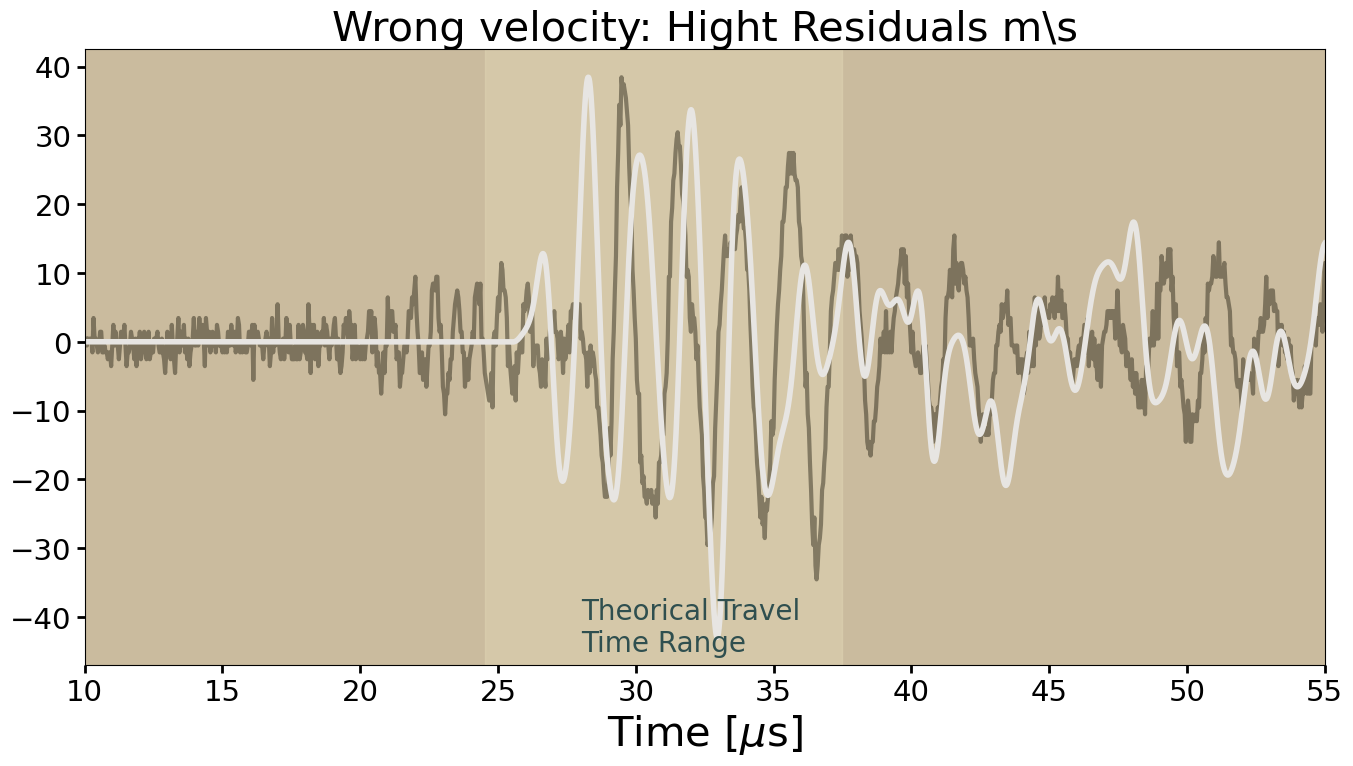

processing waveform at 0 with velocity: 1200.000000


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


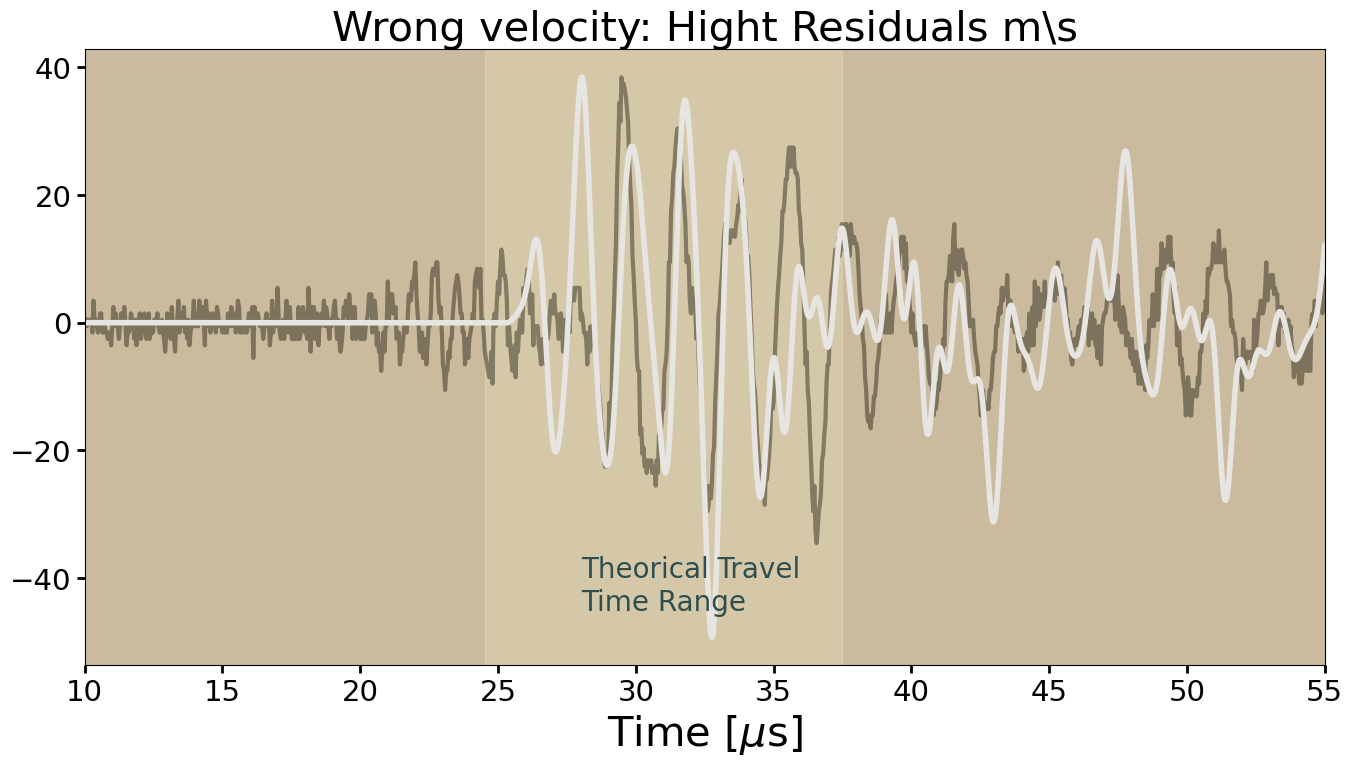

processing waveform at 0 with velocity: 1250.000000


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


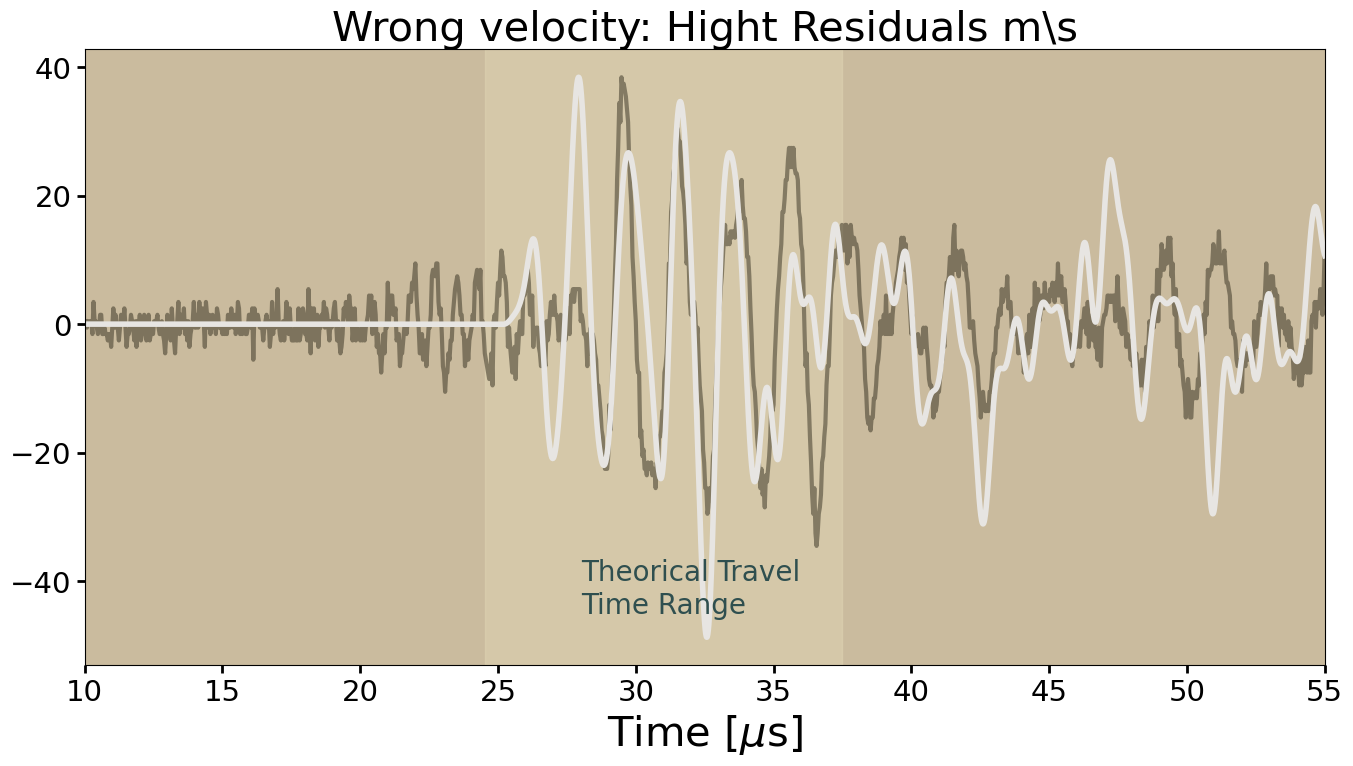

processing waveform at 0 with velocity: 1300.000000


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


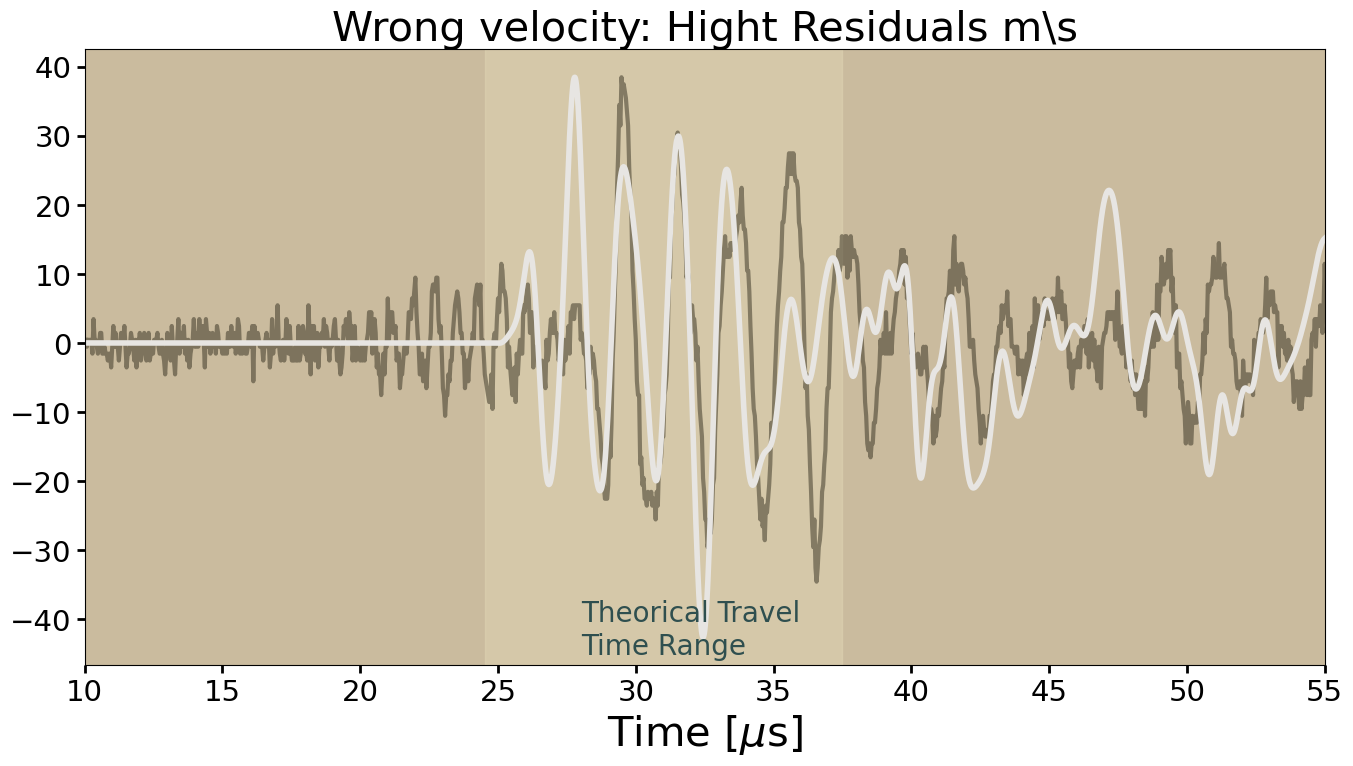

processing waveform at 0 with velocity: 1350.000000


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


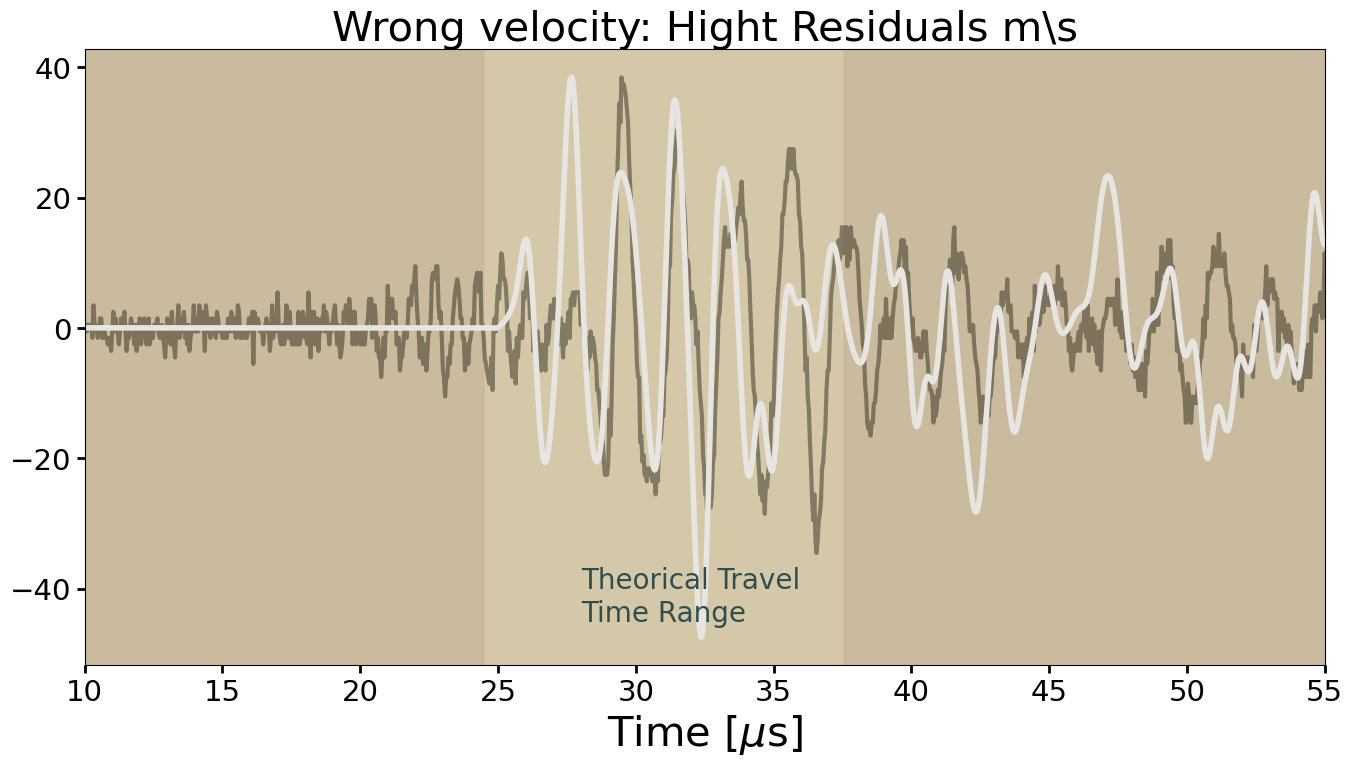

processing waveform at 0 with velocity: 1400.000000


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


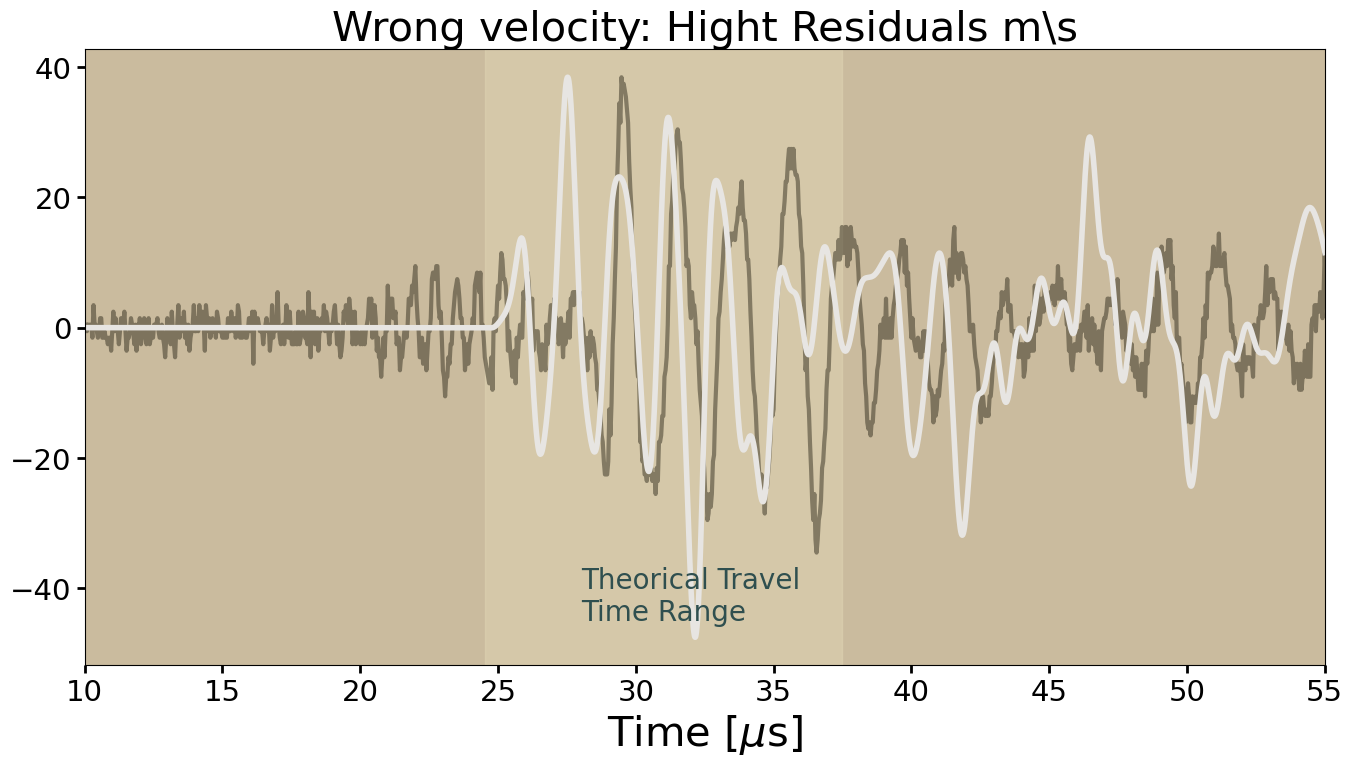

processing waveform at 0 with velocity: 1450.000000


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


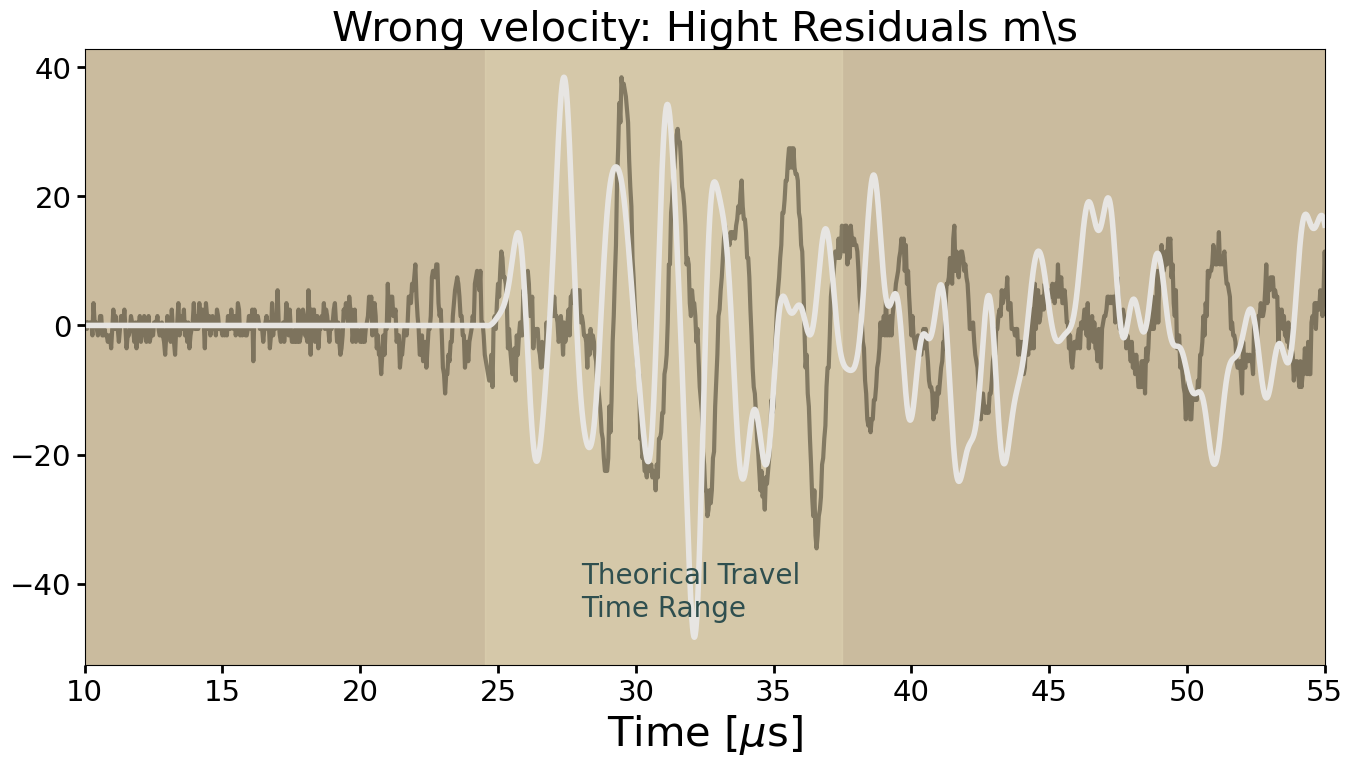

processing waveform at 0 with velocity: 1500.000000


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


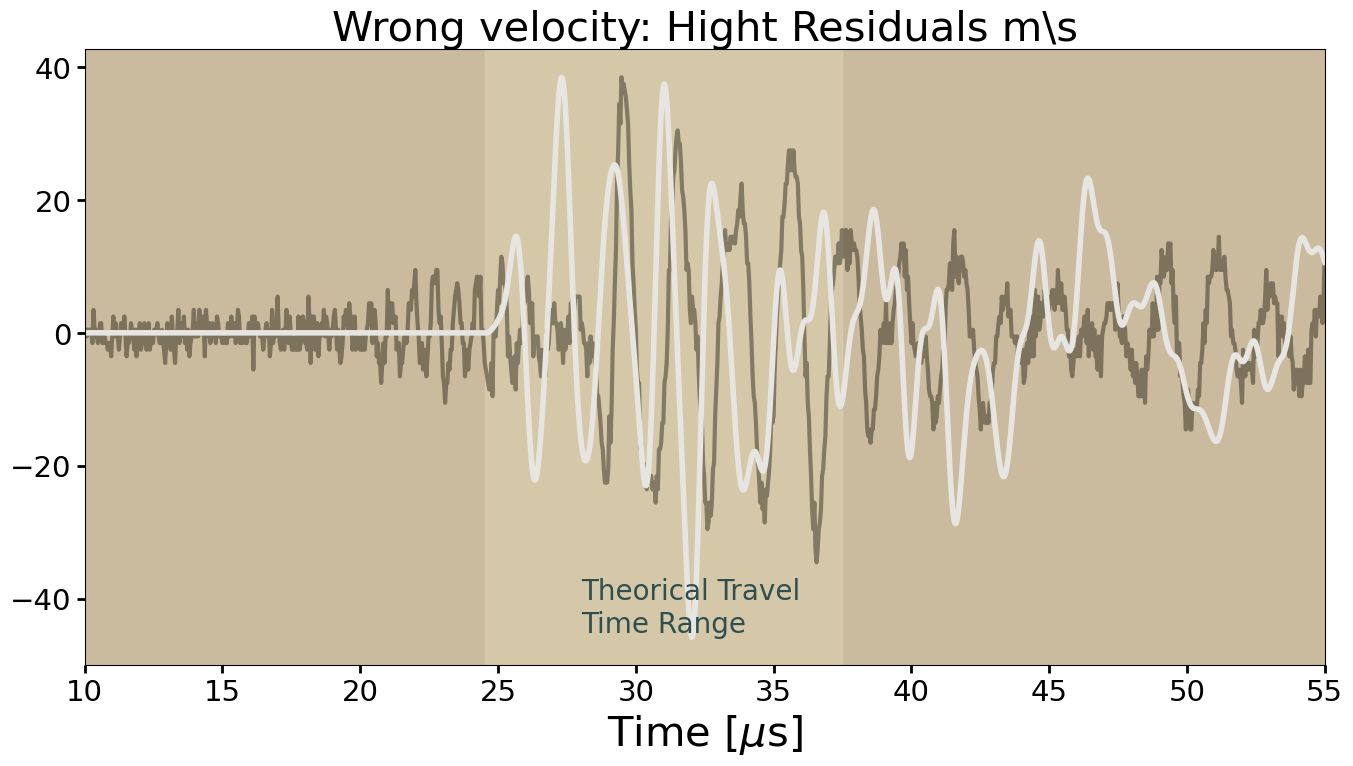

processing waveform at 0 with velocity: 1550.000000


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


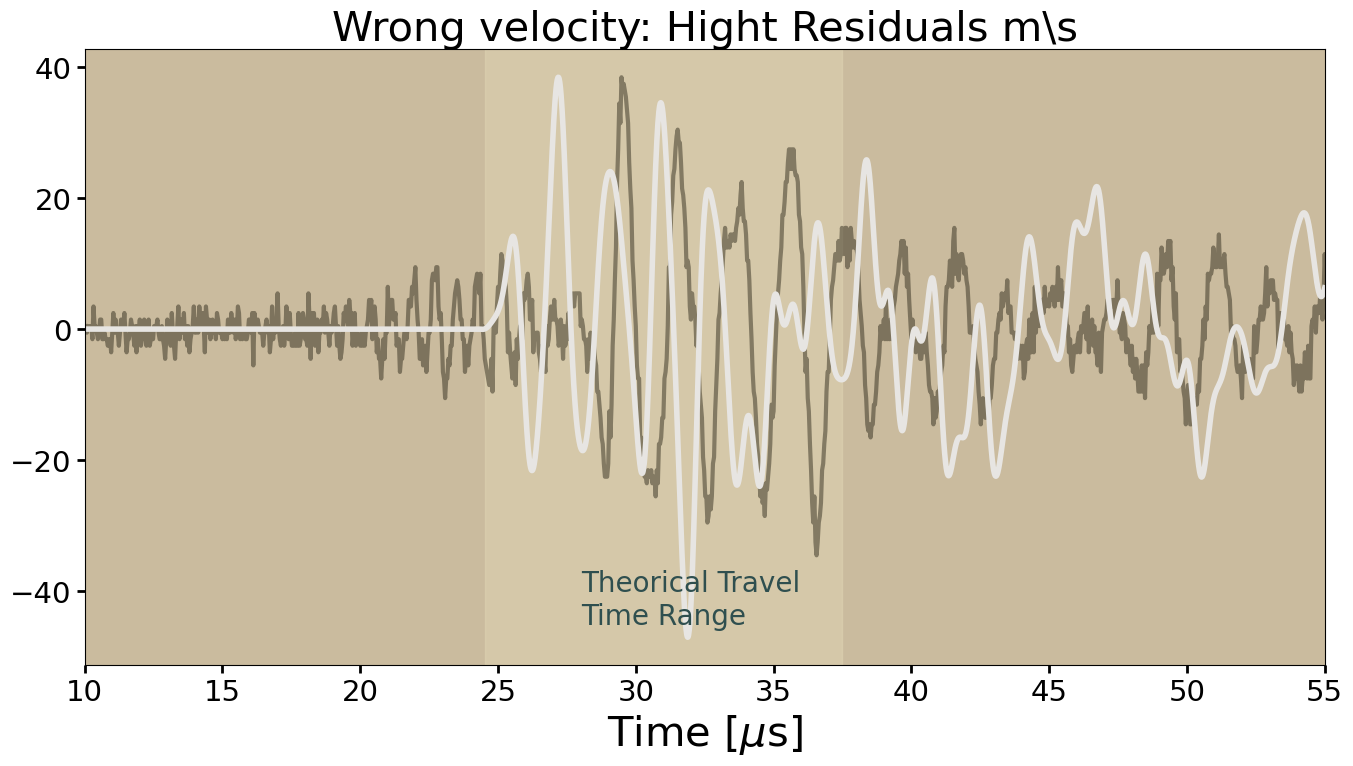

processing waveform at 0 with velocity: 1600.000000


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


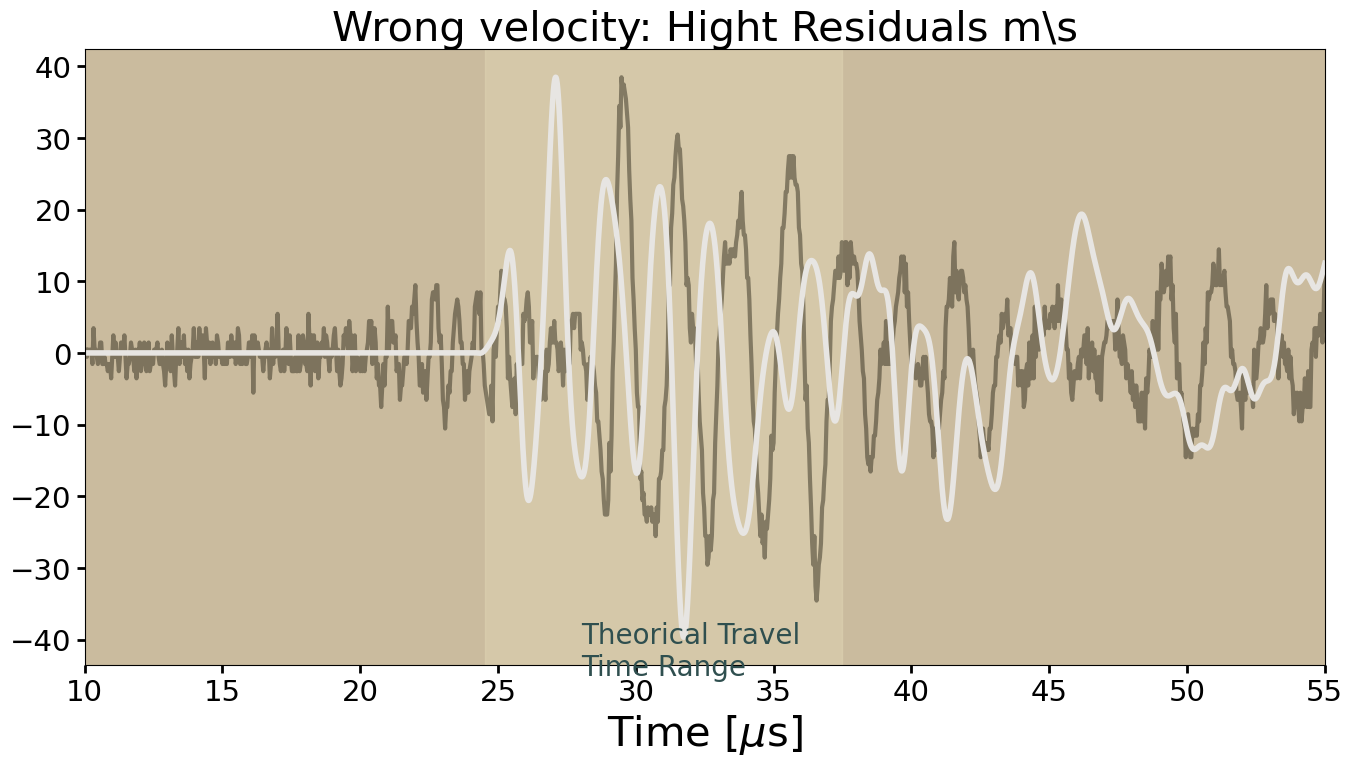

processing waveform at 0 with velocity: 1650.000000


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


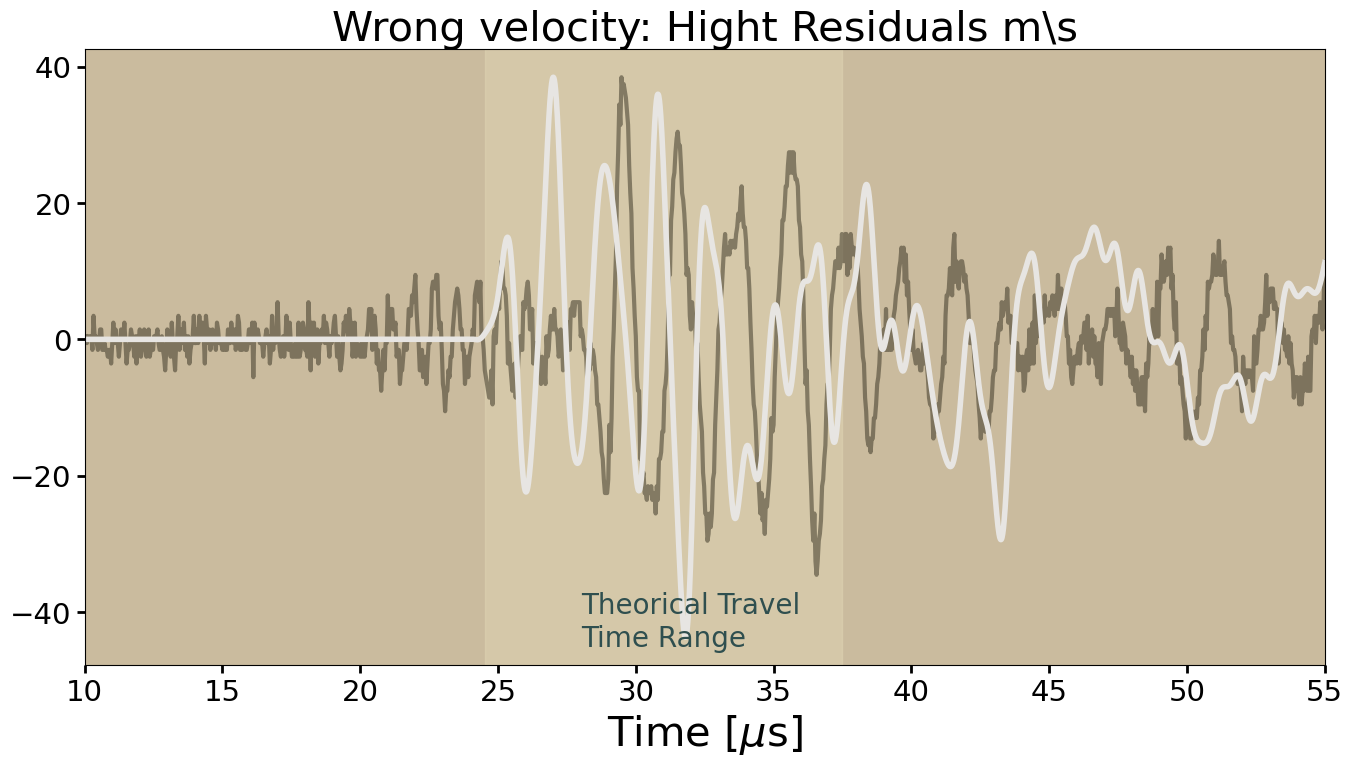

processing waveform at 0 with velocity: 1700.000000


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


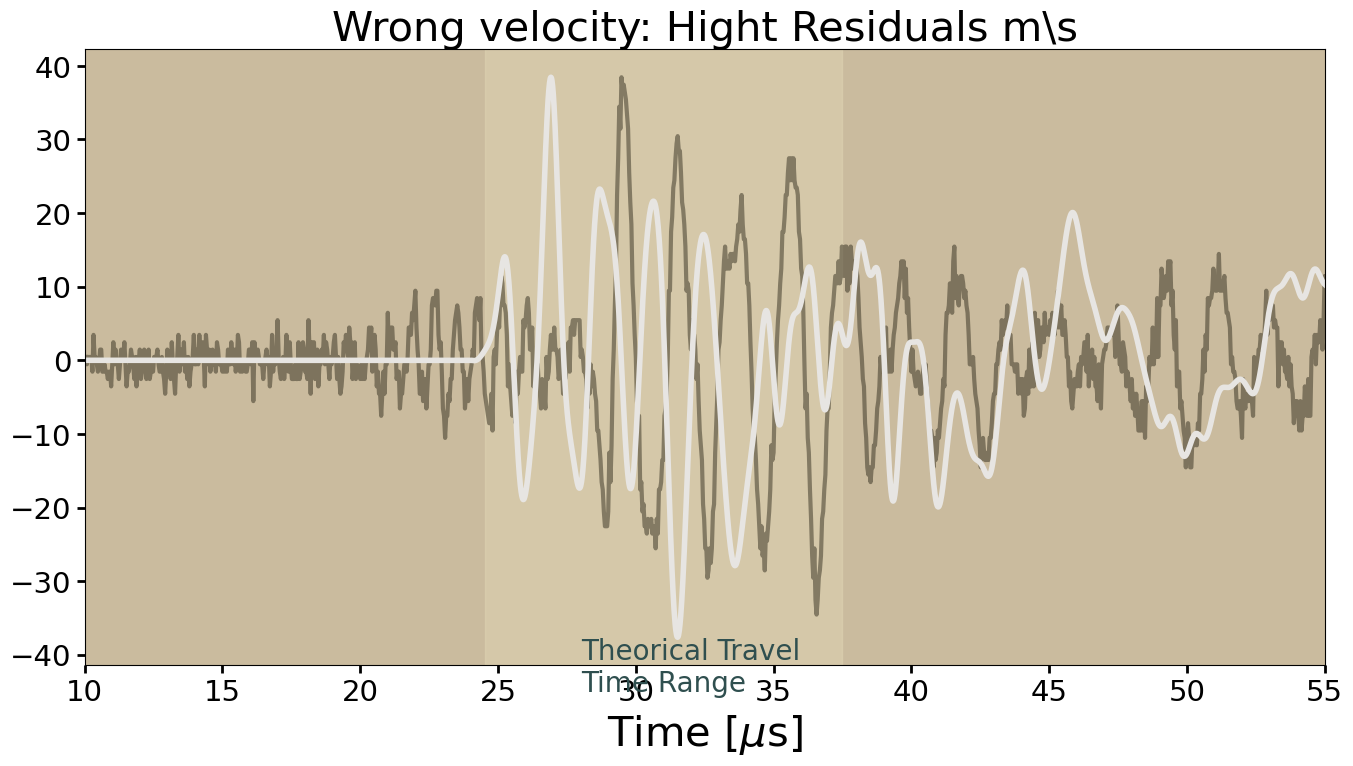

processing waveform at 0 with velocity: 1750.000000


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


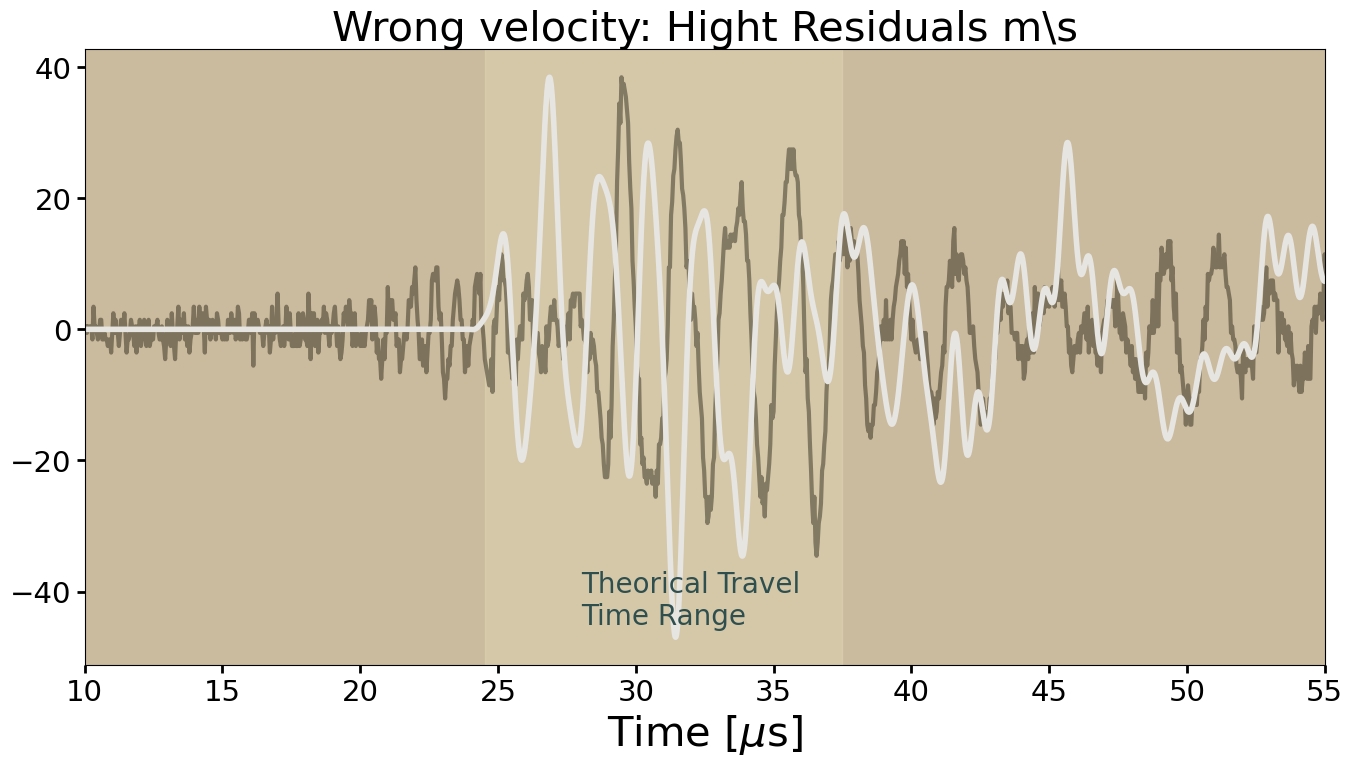

processing waveform at 0 with velocity: 1800.000000


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


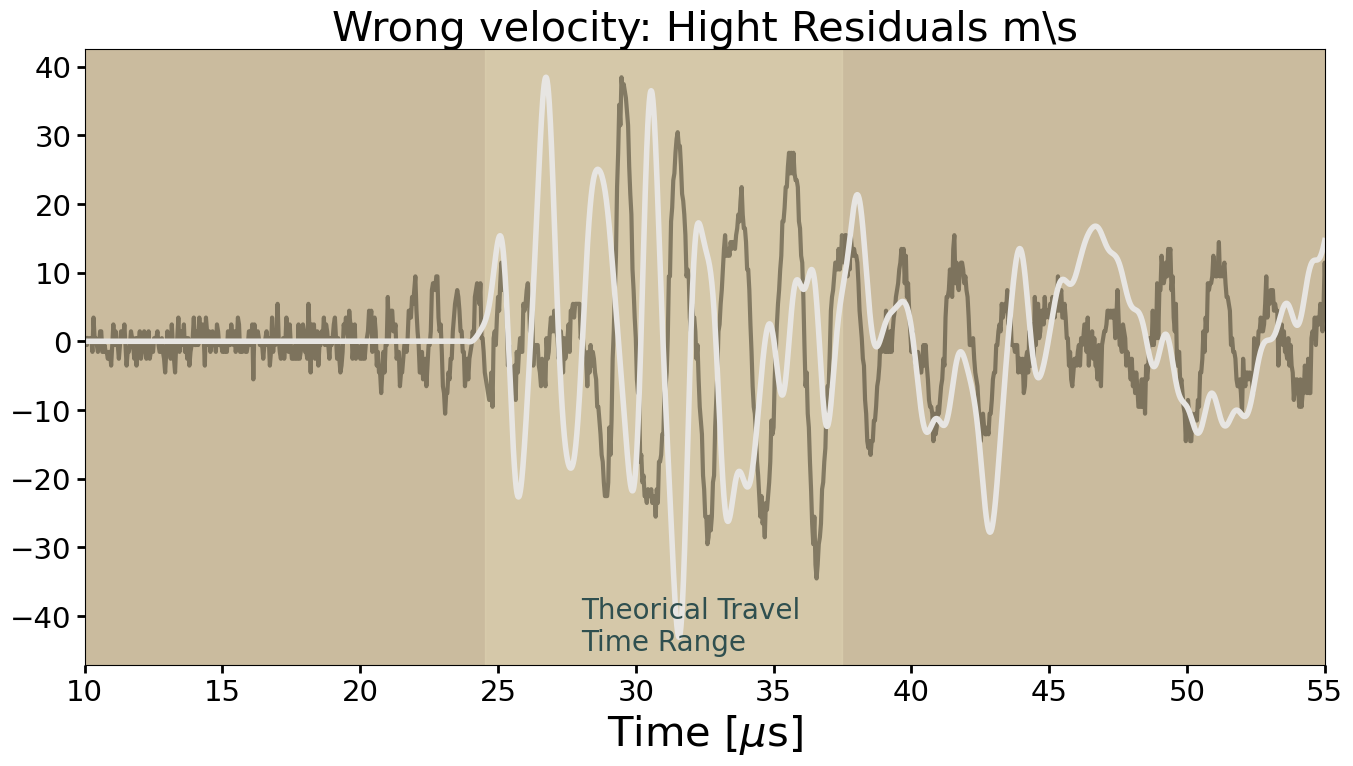

making movie


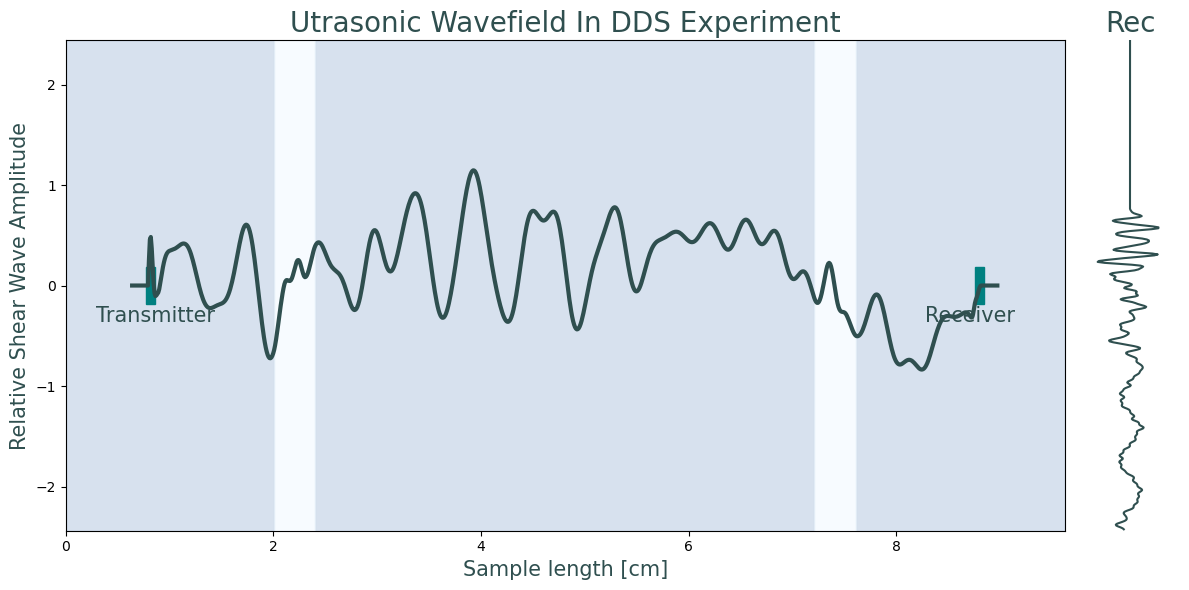

In [12]:
L2norm = np.zeros((len(data_OBS_subset[::downsampling]), len(c_gouge_list)))

# Loop over the data
for idx_waveform, (waveform_OBS, idx_travel_time, thickness_gouge_1, thickness_gouge_2) in enumerate(zip(data_OBS_subset[::downsampling], idx_travel_time_list[::downsampling], thickness_gouge_1_list[::downsampling], thickness_gouge_2_list[::downsampling])):
    if idx_waveform == 0:
        waveform_OBS = waveform_OBS - np.mean(waveform_OBS)
        sample_dimensions = [side_block_1, thickness_gouge_1, central_block, thickness_gouge_2, side_block_2]  # [cm] total length of the sample
        x_receiver = sum(sample_dimensions) - 1
        for idx_gouge, c_gouge in enumerate(c_gouge_list):
            fig = plt.figure(figsize=[16, 8])
            t_acqu = int(metadata['time_ax_acquisition'][idx_waveform * downsampling])
            print(f"processing waveform at {t_acqu} with velocity: {1e4*c_gouge:0f}")

            ax = plt.axes()
            ax.set(xlim=[10, 55])
            
            # Setting the background color of the
            # plot using set_facecolor() method
            ax.set_facecolor(colors['khaki'])  # You can choose any color you like
            ax.set_xlabel("Time [$\mu$s]", fontsize=font_size)
            # ax.axis('off')  # Turn off the axis
            ax.plot(t_OBS, waveform_OBS, color=colors['black_olive'], alpha=0.5, label=f"UW acquired at {t_acqu} s",linewidth=3.0 )
            ax.axvspan(min_travel_time, max_travel_time + time_span, color=colors['dutch_white'], alpha=0.5)
            ax.text(28, -45, 'Theorical Travel\nTime Range', ha='left', fontsize=20, color='darkslategray')

            # ax.plot(t_pulse+7, 0.1*pulse+25, color='indianred', label="Pulse used as active source", linewidth=3.0)
            plt.title(f"Observed vs Simulated wave m\s", fontsize=font_size)
            # plt.title(f"Neglecting that sensors are ... elastic media", fontsize=font_size)

            L2norm_new = DDS_UW_simulation(t_OBS, waveform_OBS, t_pulse, pulse, idx_travel_time, sample_dimensions, freq_cut,
                                            x_trasmitter, x_receiver, pzt_width, pmma_width, csteel, c_gouge, cpzt, cpmma,
                                            normalize=True, plotting=True)

            L2norm[idx_waveform, idx_gouge] = L2norm_new

            ax.tick_params(axis='both', which='both', labelsize=0.7*font_size, length=6, width=2)
            # legend = ax.legend(loc="lower left", fontsize=0.7*font_size)
            # frame = legend.get_frame()
            # frame.set_color(colors['dutch_white'])

            outfile_path_wrong_velocity = f"{outfile_path}_neglecting_wrong_velocity_{t_acqu:.0f}_velocity_{1e4 * c_gouge:.0f}.eps"
            plt.savefig(outfile_path_wrong_velocity)
            plt.show()
            plt.close(fig)

        print('making movie')
        outfile_path_movie = f"{outfile_path}_tacqu_{t_acqu:.0f}_velocity_{1e4 * c_gouge:.0f}.mp4"
        make_movie(outfile_path_movie, side_block_1, thickness_gouge_1, central_block, thickness_gouge_2, side_block_2)


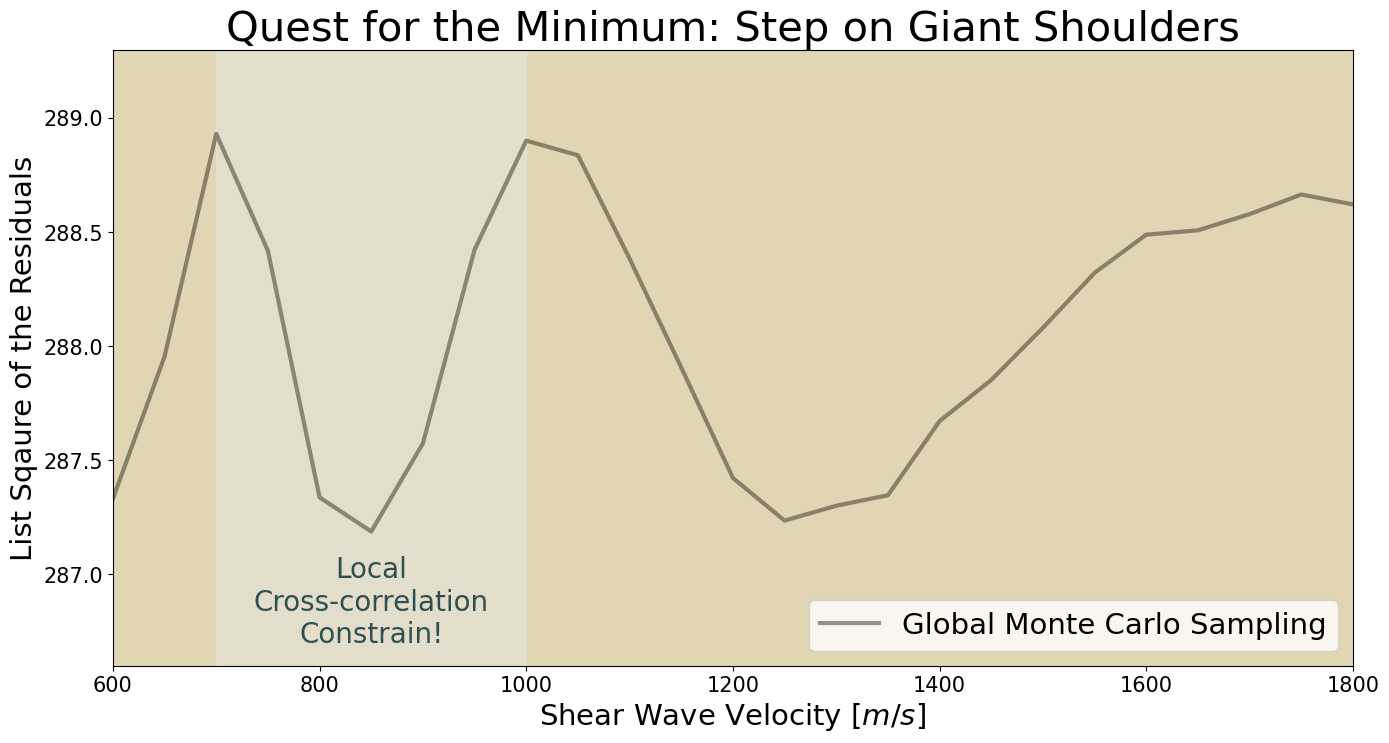

In [13]:
# # PLOT THE L2Norm results
L2norma_EGU = L2norm[0,:]
fig = plt.figure(figsize=[16, 8])
ax = plt.axes()

# Setting the background color of the plot 
# using set_facecolor() method
ax.set_facecolor(colors['dutch_white'])
ax.plot(1e4*c_gouge_list, L2norma_EGU, color=colors['black_olive'], alpha=0.5,linewidth=3.0, label= "Global Monte Carlo Sampling")
ax.axvspan(700,1000, color=colors['platinum'], alpha=0.5)
ax.text(850, 286.7, 'Local\nCross-correlation\nConstrain!', ha='center', fontsize=20, color='darkslategray')

ax.set_xlim([600, 1800])
ax.set_ylim([286.6,289.3])
ax.set_xlabel('Shear Wave Velocity [$m/s$]',fontsize=0.7*font_size)
ax.set_ylabel('List Sqaure of the Residuals',fontsize=0.7*font_size)
plt.title(f'Quest for the Minimum: Step on Giant Shoulders',fontsize=font_size)
plt.xticks(fontsize=0.5*font_size)
plt.yticks(fontsize=0.5*font_size)
ax.legend(loc="lower right", fontsize=0.7*font_size)

# outfile_path_l2norm_EGU = f"/home/michele/Desktop/Conferenza EGU 2024/l2norm_0.eps"
# plt.savefig(outfile_path_l2norm_EGU)

# np.save(outfile_path_l2norm_EGU, L2norm, allow_pickle=True)    




#### 2) Parallization on CPU using multiprocessing: THIS IS THE ONE IMPLEMENTED SO FAR IN global_optimization_velocity.py

In [14]:
# L2norm = np.zeros((len(data_OBS[::downsampling]), len(c_gouge_list)))
# # Define your parallel function
# def process_waveform(idx_waveform):
#     waveform_OBS = data_OBS[idx_waveform * downsampling] - np.mean(data_OBS[idx_waveform * downsampling])

#     # there is a problem with synchronization: the number of waves are slightly different from the rec numbers
#     # thy handling is a dute-tape, must be checked out the problem!
#     try:
#         sample_dimensions = [side_block_1, thickness_gouge_1_list[idx_waveform * downsampling], central_block, thickness_gouge_2_list[idx_waveform * downsampling], side_block_2]
#         x_receiver = sum(sample_dimensions) - 1

#         result = np.zeros(len(c_gouge_list))
#         for idx_gouge, c_gouge in enumerate(c_gouge_list):
#             L2norm_new = DDS_UW_simulation(t_OBS, waveform_OBS, t_pulse_list[choosen_pulse], pulse_list[choosen_pulse], idx_travel_time_list[idx_waveform * downsampling], 
#                             sample_dimensions, freq_cut, 
#                             x_trasmitter, x_receiver, pzt_width, pmma_width, 
#                             csteel, c_gouge, cpzt, cpmma, normalize=True, plotting=False)
#             result[idx_gouge] = L2norm_new

#     except:
#         # just get the last index of the various list instead of idx_waveform * downsampling
#         sample_dimensions = [side_block_1, thickness_gouge_1_list[-1], central_block, thickness_gouge_2_list[-1], side_block_2]
#         x_receiver = sum(sample_dimensions) - 1

#         result = np.zeros(len(c_gouge_list))
#         for idx_gouge, c_gouge in enumerate(c_gouge_list):
#             L2norm_new = DDS_UW_simulation(t_OBS, waveform_OBS, t_pulse_list[choosen_pulse], pulse_list[choosen_pulse], idx_travel_time_list[-1], 
#                             sample_dimensions, freq_cut, 
#                             x_trasmitter, x_receiver, pzt_width, pmma_width, 
#                             csteel, c_gouge, cpzt, cpmma, normalize=True, plotting=False)
#             result[idx_gouge] = L2norm_new

        
#     return idx_waveform, result

# # Set up multiprocessing
# num_processes = cpu_count()
# pool = Pool(processes=num_processes)

# # Map the function to the data
# results = pool.map(process_waveform, range(len(data_OBS[::downsampling])))

# # Close the pool
# pool.close()
# pool.join()

# # Sort the results
# results.sort(key=lambda x: x[0])

# # Extract L2norm values
# L2norm = np.array([result[1] for result in results])

In [15]:
# for idx,pulse in enumerate(L2norm):
#     fig = plt.figure()
#     plt.plot(c_gouge_list,pulse)
#     plt.xlabel('Velocity [cm/$\mu$s]')
#     plt.ylabel('L2 norm OF the residuals')
#     plt.title(f'Monte Carlo Sampling of S-wave velocity space for {idx}')

# right_v = c_gouge_list[np.argmin(L2norm, axis=1)]
# t_acquisition = metadata['time_ax_acquisition']
# t_acquisition = t_acquisition[::downsampling]
# plt.plot(t_acquisition, right_v)

#### MULTITHREAD: PARALLELIZE IN THE GOUGE LIST TOO: IT DOES NOT WORK YET!

In [16]:
# import concurrent.futures

# # Define your function to be executed in parallel
# def process_gouge(idx_gouge, c_gouge):
#     idx_waveform = ...
#     waveform_OBS = ...
#     sample_dimensions = ...
#     x_receiver = ...
#     L2norm_new = DDS_UW_simulation(t_OBS, waveform_OBS, t_pulse_list[choosen_pulse], pulse_list[choosen_pulse], idx_travel_time_list[idx_waveform], 
#                                     sample_dimensions, freq_cut, 
#                                     x_trasmitter, x_receiver, pzt_width, pmma_width, 
#                                     csteel, c_gouge, cpzt, cpmma, normalize=True, plotting=False)
#     return L2norm_new

# # Create a ThreadPoolExecutor with a maximum number of worker threads
# max_workers = None  # Use None to automatically determine the number of threads based on the system's CPU count
# with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
#     # Submit the tasks for parallel execution
#     futures = [executor.submit(process_gouge, idx_gouge, c_gouge) for idx_gouge, c_gouge in enumerate(c_gouge_list)]

#     # Retrieve the results as they become available
#     results = [future.result() for future in concurrent.futures.as_completed(futures)]

# # Now results contains the L2norm values computed in parallel for each idx_gouge


#### GPU PARALLELIZATION VERSION: IT DOES NOT WORK YET! 

In [17]:

# downsampling = 100
# choosen_pulse = 0
# pulse = pulse_list[choosen_pulse]
# t_pulse = t_pulse_list[choosen_pulse]

# # Define a new parallel function to compute L2norm_new
# def process_gouge(args):
#     idx_gouge, waveform_OBS, sample_dimensions, x_receiver, t_pulse, pulse, idx_travel_time = args
#     waveform_OBS = cp.asarray(waveform_OBS)
#     sample_dimensions = cp.asarray(sample_dimensions)

#     L2norm_new = DDS_UW_simulation(cp.asnumpy(t_OBS), cp.asnumpy(waveform_OBS), cp.asnumpy(t_pulse), cp.asnumpy(pulse), idx_travel_time, 
#                                     cp.asnumpy(sample_dimensions), freq_cut, x_trasmitter, x_receiver, 
#                                     pzt_width, pmma_width, csteel, c_gouge, cpzt, cpmma, 
#                                     normalize=True, plotting=False)
#     return idx_gouge, L2norm_new

# # Define your parallel function
# def process_waveform(idx_waveform):
#     waveform_OBS = data_OBS[idx_waveform * downsampling] - np.mean(data_OBS[idx_waveform * downsampling])

#     sample_dimensions = [side_block_1, thickness_gouge_1_list[idx_waveform * downsampling], 
#                          central_block, thickness_gouge_2_list[idx_waveform * downsampling], side_block_2]
#     x_receiver = sum(sample_dimensions) - 1

#     # Prepare arguments for process_gouge function
#     args_list = [(idx_gouge, waveform_OBS, sample_dimensions, x_receiver, t_pulse, pulse, idx_travel_time_list[idx_waveform * downsampling]) for idx_gouge in range(len(c_gouge_list))]

#     # Map the function to the data
#     results = map(process_gouge, args_list)

#     # Sort the results
#     results = sorted(results, key=lambda x: x[0])

#     # Extract L2norm_new values
#     L2norm_new = cp.array([result[1] for result in results])

#     return idx_waveform, L2norm_new

# # Set up multiprocessing
# num_processes = cpu_count()
# pool = Pool(processes=num_processes)

# # Map the function to the data
# results = pool.map(process_waveform, range(len(data_OBS[::downsampling])))

# # Close the pool
# pool.close()
# pool.join()

# # Sort the results
# results.sort(key=lambda x: x[0])

# # Extract L2norm values
# L2norm = cp.array([result[1] for result in results])
